In [1]:
from utils_v1 import *


In [2]:
from icecream import ic
import pdb
from sklearn import metrics
import importlib
import utils_v1
import pathlib
import cv2
import sys
import numpy as np
from src import metrics as _metrics
import src.loss as loss
from src.dataset import (
    MultipleDates,
    PA, PADeforestationTime, PADistanceMap, PAMultipleDates,
    MT, MTDeforestationTime,
    MTMultipleDates
)

# from src.dataset_legacy import MTDeforestationTime
from src import training_generator as generator
from src.patchesHandler import PatchesHandler, PatchesHandlerMultipleDates


In [3]:
from enum import Enum
Predictor = Enum('Predictor', 'pred_var MI pred_entropy KL pred_entropy_single')
predictor = Predictor.pred_entropy
# predictor = Predictor.pred_var
# predictor = Predictor.MI
# predictor = Predictor.KL

# predictor = Predictor.pred_entropy_single


In [4]:
useLessInferenceRuns = False
reducedInferenceRuns = 30

In [5]:
training = False
save_probabilities = False
loadInference = False


addPastDeforestationInput = True
'''
if training == True:
	dates = [2017, 2018]
else:
	dates = [2018, 2019]
if training == True:
	dates = [2018, 2019]
else:
	dates = [2019, 2020]
'''
# dates = [2018, 2019]
# dataset = PAMultipleDates(dates = dates, # dates = [2017, 2018, 2019]. [2018, 2019]. [2015, 2016, 2017, 2018]
# 	addPastDeforestationInput = addPastDeforestationInput,
# 	borderBuffer = 2)	
dates = [2019, 2020]
dataset = MTMultipleDates(dates = dates, # dates = [2016,2017,2018,2019]
	addPastDeforestationInput = addPastDeforestationInput,
	borderBuffer = 2)	

if issubclass(type(dataset), MultipleDates):
	patchesHandler = PatchesHandlerMultipleDates(
		dataset)
else:
	patchesHandler = PatchesHandler()

inference_times = 10


if training == False:


	if type(dataset) == PAMultipleDates:
		# exp_ids = [103, 104, 105, 106, 107, 118, 119, 120, 121, 122] # same date
		exp_ids = [123, 124, 125, 126, 127, 128, 129, 131, 1122, 1121] # earlier date

	if type(dataset) == MTMultipleDates:
		# exp_ids = [108, 109, 110, 111, 112, 113, 114, 115, 116, 117] # same date
		exp_ids = [130, 132, 133, 134, 135, 136, 137, 1125, 1124, 1123] # earlier date

else:
	# exp = 13 # Multiple dates. using fixed fixed past deforestation distance
	exp = 140

ic| list(self.date_ids): [0]
ic| self.image_channels: [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]]
ic| self.input_image_shape: 21
ic| self.dataset.image_channels: [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]]


In [6]:
exp_ids

[130, 132, 133, 134, 135, 136, 137, 1125, 1124, 1123]

In [7]:
figures_path = 'output/figures' + dataset.__class__.__name__ + '/'
pathlib.Path(figures_path).mkdir(parents=True, exist_ok=True)
title_name = 'ResUnet'

In [8]:
# ic(type(dataset), exp, dataset.dates)


In [9]:
# Loading reference
label_mask = dataset.loadLabel()
print('Mask label shape: ', '\n', label_mask.shape, '\n', 'Unique values: ', '\n', np.unique(label_mask))

D:/Jorge/datasets/deforestation/MT/deforestation_past_years.tif
Loaded deforestation past years


ic| np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([161124576,   1332784,    240796,    338545,    313901,    287191,
                                                                       708581,    648966,    876898,   1007787,   1098901,   1054092,
                                                                      2096062,   2473828,   1400992], dtype=int64))


Label where deforestation past years is actual date (2020) = 1


ic| np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([161124576,   1332784,    240796,    338545,    313901,    287191,
                                                                       708581,    648966,    876898,   1007787,   1098901,   1054092,
                                                                      2096062,   2473828,   1400992], dtype=int64))


Past deforestation different from 0 (no deforestation)


ic| np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([161124576,   1332784,    240796,    338545,    313901,    287191,
                                                                       708581,    648966,    876898,   1007787,   1098901,   1054092,
                                                                      2096062,   2473828,   1400992], dtype=int64))


Past deforestation before 2008 is 2
D:/Jorge/datasets/deforestation/MT/deforestation_before_2008/deforestation_before_2008_MT.tif


ic| np.unique(label_past_deforestation_before_2008, return_counts=True): (array([  0, 215], dtype=uint8), array([122623260,  52380640], dtype=int64))
ic| np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([161124576,   1332784,    240796,    338545,    313901,    287191,
                                                                       708581,    648966,    876898,   1007787,   1098901,   1054092,
                                                                      2096062,   2473828,   1400992], dtype=int64))
ic| label_per_date.shape: (16795, 10420, 1)


Mask label shape:  
 (16795, 10420, 1) 
 Unique values:  
 [0 1 2]


In [10]:
# np.save('label_not_independent.npy', label_mask)


In [11]:
# Creating tile mask

mask_tiles = create_mask(label_mask.shape[0], label_mask.shape[1], 
        grid_size=(dataset.grid_x, dataset.grid_y))
label_mask = label_mask[:mask_tiles.shape[0], :mask_tiles.shape[1]]

Tiles size:  3359 2084
Mask size:  (16795, 10420)


In [12]:
label_mask.dtype

dtype('uint8')

In [13]:
label_mask_current_deforestation = dataset.getLabelCurrentDeforestation(
        label_mask)

In [14]:
label_mask.dtype

dtype('uint8')

In [15]:
# Loading image stack
image_stack = dataset.loadInputImage()

print('Image shape: ', image_stack.shape)
channels = image_stack.shape[-1]
image_stack = image_stack[:mask_tiles.shape[0], :mask_tiles.shape[1],:]
print('mask: ',mask_tiles.shape)
print('image stack: ', image_stack.shape)
print('ref :', label_mask.shape)
#plt.imshow(mask_tiles)

ic| image_stack.shape: (16795, 10420, 21)


Image shape:  (16795, 10420, 21)
mask:  (16795, 10420)
image stack:  (16795, 10420, 21)
ref : (16795, 10420, 1)


In [16]:
np.unique(image_stack[...,0], return_counts=True)

(array([0.        , 0.07692308, 0.15384616, 0.23076925, 0.30769232,
        0.3846154 , 0.4615385 , 0.53846157, 0.61538464, 0.6923077 ,
        0.7692308 , 0.84615386, 0.923077  , 1.        ], dtype=float32),
 array([112618766,   2096062,   1054083,   1098901,   1007787,    876898,
           648966,    708581,    287191,    313901,    338545,    240796,
          1332783,  52380640], dtype=int64))

(-0.5, 10419.5, 16794.5, -0.5)

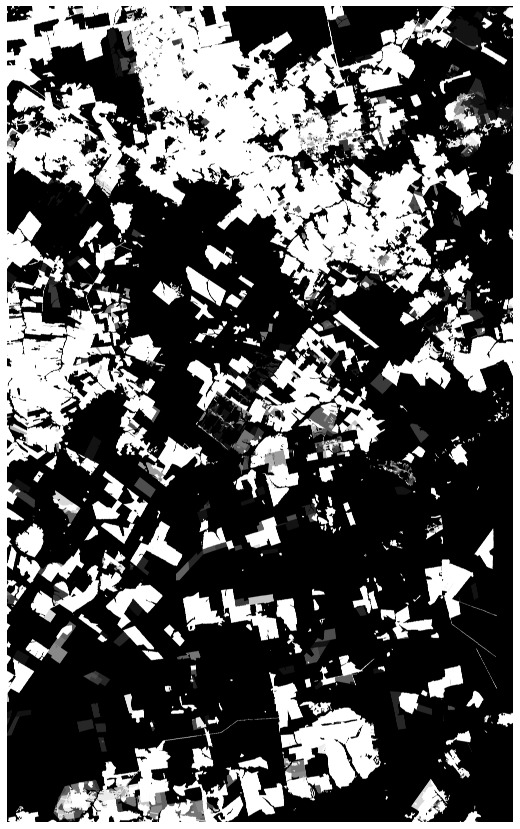

In [17]:


plt.figure(figsize=(15,15))
plt.imshow(image_stack[...,0], cmap=plt.cm.gray)

# title_name = 'ResUnet'
plt.axis('off')
# plt.savefig('output/figures/Para' + title_name + ' error mask.png', dpi=150, bbox_inches='tight')

In [18]:
ic(image_stack.shape)
channels = image_stack.shape[-1]
ic(channels)

ic| image_stack.shape: (16795, 10420, 21)
ic| channels: 21


21

In [19]:
mask_tr_val, mask_amazon_ts = dataset.getTrainValTestMasks(mask_tiles)


Training tiles:  [2, 4, 5, 6, 7, 12, 14, 15, 18, 21, 23, 24]
Validation tiles:  [9, 11, 25]
Test tiles:  [1, 3, 8, 10, 13, 16, 17, 19, 20, 22]


In [20]:

patch_size = 128
if training == True:

    # Extracting patches from the idx matrix
    overlap = 0.7
    batch_size = 32
    im_idx = patchesHandler.create_idx_image(label_mask)


In [21]:
import importlib
if training == True:
	coords = patchesHandler.extract_patches(
		im_idx, patch_size=(patch_size, patch_size, 2), 
		overlap=overlap)

	coords_train, coords_val = patchesHandler.trainTestSplit(coords,
		mask_tr_val, patch_size=(patch_size, patch_size, 2))

	ic(coords_train.shape, coords_val.shape)
	# del im_idx

In [22]:
label_mask.shape

(16795, 10420, 1)

(-0.5, 10419.5, 16794.5, -0.5)

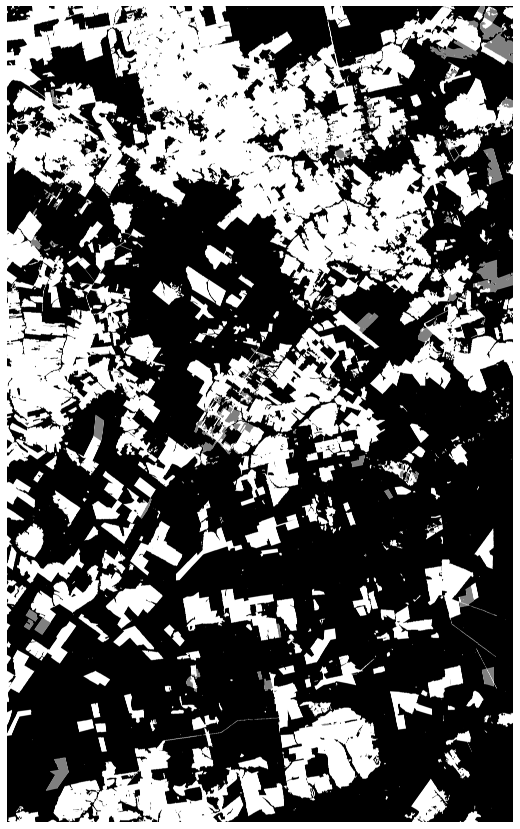

In [23]:

plt.figure(figsize=(15,15))
if type(dataset) != PADeforestationTime and type(dataset) != MTDeforestationTime:
    plt.imshow(label_mask[...,-1], cmap=plt.cm.gray)
else:
    plt.imshow(label_mask, cmap=plt.cm.gray)

# title_name = 'ResUnet'
plt.axis('off')
# plt.savefig('output/figures/Para' + title_name + ' error mask.png', dpi=150, bbox_inches='tight')

In [24]:
np.unique(label_mask)

array([0, 1, 2], dtype=uint8)

In [25]:
if training == True:
    print(coords_train)

In [26]:
if training == True:

    # Keeping patches with 2% of def class
    coords_train = patchesHandler.retrieve_idx_percentage(label_mask, coords_train, 
			patch_size, pertentage = 0.2)
    coords_val = patchesHandler.retrieve_idx_percentage(label_mask, coords_val, 
			patch_size, pertentage = 0.2)
    print('training samples: ', coords_train.shape, 
			'validation samples: ', coords_val.shape)


In [27]:
'''
import src.patchesHandler as sp
importlib.reload(sp)

patchesHandler = sp.PatchesHandlerMultipleDates(
		dataset)
'''

'\nimport src.patchesHandler as sp\nimportlib.reload(sp)\n\npatchesHandler = sp.PatchesHandlerMultipleDates(\n\t\tdataset)\n'

In [28]:
import src.plot as _plt
importlib.reload(_plt)

<module 'src.plot' from 'd:\\Jorge\\deforestation_uncertainty\\src\\plot.py'>

In [29]:
'''
if training == True:
    idx = 3100
    print(coords_train[idx])
    image_patch, reference_patch = patchesHandler.getPatch(
        image_stack, label_mask, coords_train, idx = idx)
    ic(np.mean(image_patch[...,[4,5,6]]), np.mean(image_patch[...,[14,15,16]]))
    _plt.plotCropSample5(image_stack[...,[4,5,6]], image_stack[...,[14,15,16]], 
            image_stack[...,[24,25,26]], image_stack[...,[34,35,36]],
            image_stack[...,[44,45,46]],            
            lims = None, 
            titles = ['2015', '2016', '2017', '2018', '2019'],
            cmaps = [plt.cm.gray, plt.cm.gray, plt.cm.gray, plt.cm.gray, plt.cm.gray],
            maskBackground = [False, False, False, False, False],
            invertMask = [False, False, False, False, False])
'''

"\nif training == True:\n    idx = 3100\n    print(coords_train[idx])\n    image_patch, reference_patch = patchesHandler.getPatch(\n        image_stack, label_mask, coords_train, idx = idx)\n    ic(np.mean(image_patch[...,[4,5,6]]), np.mean(image_patch[...,[14,15,16]]))\n    _plt.plotCropSample5(image_stack[...,[4,5,6]], image_stack[...,[14,15,16]], \n            image_stack[...,[24,25,26]], image_stack[...,[34,35,36]],\n            image_stack[...,[44,45,46]],            \n            lims = None, \n            titles = ['2015', '2016', '2017', '2018', '2019'],\n            cmaps = [plt.cm.gray, plt.cm.gray, plt.cm.gray, plt.cm.gray, plt.cm.gray],\n            maskBackground = [False, False, False, False, False],\n            invertMask = [False, False, False, False, False])\n"

In [30]:
inputSnipShow = False

In [31]:
if training == True and inputSnipShow == True:
    idx = 2800
    print(coords_train[idx])
    image_patch, reference_patch = patchesHandler.getPatch(
        image_stack, label_mask, coords_train, idx = idx)
    ic(np.mean(image_patch[...,[1,2,3]]), np.mean(image_patch[...,[11,12,13]]))
    _plt.plotCropSample4(image_patch[...,[1,2,3]], image_patch[...,[11,12,13]], 
            reference_patch, reference_patch,
            lims = None, 
            titles = ['Optical T0', 'Optical T1', 'Reference', 'Reference 2'],
            cmaps = [plt.cm.gray, plt.cm.gray, plt.cm.gray, plt.cm.gray],
            maskBackground = [False, False, False, False],
            invertMask = [False, False, False, False])

In [32]:
'''
if training == True:

    idx = 6000
    print(coords_train[idx])
    image_patch, reference_patch = patchesHandler.getPatch(
        image_stack, label_mask, coords_train, idx = idx)
    ic(np.mean(image_patch[...,[1,2,3]]), np.mean(image_patch[...,[11,12,13]]))
    _plt.plotCropSample4(image_patch[...,[1,2,3]], image_patch[...,[11,12,13]], 
            reference_patch, reference_patch,
            lims = None, 
            titles = ['Optical T0', 'Optical T1', 'Reference', 'Reference 2'],
            cmaps = [plt.cm.gray, plt.cm.gray, plt.cm.gray, plt.cm.gray],
            maskBackground = [False, False, False, False],
            invertMask = [False, False, False, False])
'''

"\nif training == True:\n\n    idx = 6000\n    print(coords_train[idx])\n    image_patch, reference_patch = patchesHandler.getPatch(\n        image_stack, label_mask, coords_train, idx = idx)\n    ic(np.mean(image_patch[...,[1,2,3]]), np.mean(image_patch[...,[11,12,13]]))\n    _plt.plotCropSample4(image_patch[...,[1,2,3]], image_patch[...,[11,12,13]], \n            reference_patch, reference_patch,\n            lims = None, \n            titles = ['Optical T0', 'Optical T1', 'Reference', 'Reference 2'],\n            cmaps = [plt.cm.gray, plt.cm.gray, plt.cm.gray, plt.cm.gray],\n            maskBackground = [False, False, False, False],\n            invertMask = [False, False, False, False])\n"

In [33]:
if training == True and inputSnipShow == True:

    idx = 97
    print(coords_train[idx])
    image_patch, reference_patch = patchesHandler.getPatch(
        image_stack, label_mask, coords_train, idx = idx)
    ic(np.mean(image_patch[...,[1,2,3]]), np.mean(image_patch[...,[11,12,13]]))
    _plt.plotCropSample4(image_patch[...,[1,2,3]], image_patch[...,[11,12,13]], 
            reference_patch, reference_patch,
            lims = None, 
            titles = ['Optical T0', 'Optical T1', 'Reference', 'Reference 2'],
            cmaps = [plt.cm.gray, plt.cm.gray, plt.cm.gray, plt.cm.gray],
            maskBackground = [False, False, False, False],
            invertMask = [False, False, False, False])

In [34]:
if training == True and inputSnipShow == True:

    idx = 1200
    print(coords_train[idx])
    image_patch, reference_patch = patchesHandler.getPatch(
        image_stack, label_mask, coords_train, idx = idx)
    ic(np.mean(image_patch[...,[1,2,3]]), np.mean(image_patch[...,[11,12,13]]))
    _plt.plotCropSample4(image_patch[...,[1,2,3]], image_patch[...,[11,12,13]], 
            reference_patch, reference_patch,
            lims = None, 
            titles = ['Optical T0', 'Optical T1', 'Reference', 'Reference 2'],
            cmaps = [plt.cm.gray, plt.cm.gray, plt.cm.gray, plt.cm.gray],
            maskBackground = [False, False, False, False],
            invertMask = [False, False, False, False])

In [35]:
inputSnipShow = False
if training == True and inputSnipShow == True:

    idx = 400
    print(coords_train[idx])
    image_patch, reference_patch = patchesHandler.getPatch(
        image_stack, label_mask, coords_train, idx = idx)
    ic(np.mean(image_patch[...,[1,2,3]]), np.mean(image_patch[...,[11,12,13]]))
    _plt.plotCropSample4(image_patch[...,[1,2,3]], image_patch[...,[11,12,13]], 
            reference_patch, reference_patch,
            lims = None, 
            titles = ['Optical T0', 'Optical T1', 'Reference', 'Reference 2'],
            cmaps = [plt.cm.gray, plt.cm.gray, plt.cm.gray, plt.cm.gray],
            maskBackground = [False, False, False, False],
            invertMask = [False, False, False, False])

In [36]:
'''
if training == True:

    idx = 6000
    print(coords_train[idx])
    image_patch, reference_patch = patchesHandler.getPatch(
        image_stack, label_mask, coords_train, idx = idx)
    ic(np.mean(image_patch[...,[1,2,3]]), np.mean(image_patch[...,[11,12,13]]))
    _plt.plotCropSample4(image_patch[...,[1,2,3]], image_patch[...,[11,12,13]], 
            reference_patch, reference_patch,
            lims = None, 
            titles = ['Optical T0', 'Optical T1', 'Reference', 'Reference 2'],
            cmaps = [plt.cm.gray, plt.cm.gray, plt.cm.gray, plt.cm.gray],
            maskBackground = [False, False, False, False],
            invertMask = [False, False, False, False])
'''

"\nif training == True:\n\n    idx = 6000\n    print(coords_train[idx])\n    image_patch, reference_patch = patchesHandler.getPatch(\n        image_stack, label_mask, coords_train, idx = idx)\n    ic(np.mean(image_patch[...,[1,2,3]]), np.mean(image_patch[...,[11,12,13]]))\n    _plt.plotCropSample4(image_patch[...,[1,2,3]], image_patch[...,[11,12,13]], \n            reference_patch, reference_patch,\n            lims = None, \n            titles = ['Optical T0', 'Optical T1', 'Reference', 'Reference 2'],\n            cmaps = [plt.cm.gray, plt.cm.gray, plt.cm.gray, plt.cm.gray],\n            maskBackground = [False, False, False, False],\n            invertMask = [False, False, False, False])\n"

In [37]:
# Creating train and validation data generator
# importlib.reload(patchesHandler)
import pdb
if training == True:

	train_datagen = ImageDataGenerator()
	valid_datagen = ImageDataGenerator()
	# pdb.set_trace()
	len_X_train = coords_train.shape[0]
	len_X_valid = coords_val.shape[0]

	train_gen = train_datagen.flow(
			np.expand_dims(np.expand_dims(coords_train, axis = -1), axis = -1), 
			np.expand_dims(np.expand_dims(coords_train, axis = -1), axis = -1),
			batch_size=batch_size,
			shuffle=True)
	# pdb.set_trace()

	valid_gen = valid_datagen.flow(
			np.expand_dims(np.expand_dims(coords_val, axis = -1), axis = -1), 
			np.expand_dims(np.expand_dims(coords_val, axis = -1), axis = -1),
			batch_size=batch_size,
			shuffle=False)

	number_class = 3
	train_gen_batch = patchesHandler.batch_generator(train_gen,
			image_stack, label_mask, patch_size, number_class)
	valid_gen_batch = patchesHandler.batch_generator(valid_gen,
			image_stack, label_mask, patch_size, number_class)

	#del image_stack

In [38]:
# Creating folder for the experiment

# path_exp = dataset.paths.experiment + 'exp' + str(exp)
# path_models = path_exp+'/models'
# path_maps = path_exp+'/pred_maps'

# if not os.path.exists(path_exp):
#     os.makedirs(path_exp)   
# if not os.path.exists(path_models):
#     os.makedirs(path_models)   
# if not os.path.exists(path_maps):
#     os.makedirs(path_maps)
    
times = 1
method = 'resunet'
nb_filters = [16, 32, 64, 128, 256]
weights = [0.1, 0.9, 0]

In [39]:
if type(patchesHandler) == PatchesHandlerMultipleDates:
	channels = patchesHandler.input_image_shape

In [40]:
# path_exp

In [41]:
channels

21

In [42]:
image_stack.shape

(16795, 10420, 21)

In [43]:

metrics_all = []
if training == True:
    for tm in range(0,times):
        print('time: ', tm)

        rows = patch_size
        cols = patch_size
        adam = Adam(lr = 1e-3 , beta_1=0.9)
        
        loss = loss.weighted_categorical_crossentropy(weights)
        
        input_shape = (rows, cols, channels)
        model = build_resunet_dropout_spatial(input_shape, nb_filters, number_class)
        
        model.compile(optimizer=adam, loss=loss, metrics=['accuracy'])
        model.summary()

        earlystop = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=10, verbose=1, mode='min')
        checkpoint = ModelCheckpoint(path_models+ '/' + method +'_'+str(tm)+'.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')
        lr_reduce = ReduceLROnPlateau(factor=0.9, min_delta=0.0001, patience=5, verbose=1)
        callbacks_list = [earlystop, checkpoint]
        # train the model
        start_training = time.time()
        history = model.fit_generator(train_gen_batch,
                                steps_per_epoch=len_X_train*3//train_gen.batch_size,
                                validation_data=valid_gen_batch,
                                validation_steps=len_X_valid*3//valid_gen.batch_size,
                                epochs=100,
                                callbacks=callbacks_list)
        end_training = time.time() - start_training
        # metrics_all.append(end_training)
        del model

    # Saving training time
    # np.save(path_exp+'/metrics_tr.npy', metrics_all)
    del train_gen_batch, valid_gen_batch

In [44]:
if training == True:
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.savefig('loss_history.png')

In [45]:
image_stack.shape

(16795, 10420, 21)

In [46]:
if type(dataset) != PADeforestationTime and type(dataset) != MTDeforestationTime:
    patchesHandler.dataset.image_channels[-1]

In [47]:
if type(dataset) == PAMultipleDates:
	channels = patchesHandler.input_image_shape
	image_stack = image_stack[..., patchesHandler.dataset.image_channels[-1]]
	label_mask = label_mask[...,-1]

In [48]:
image_stack.shape

(16795, 10420, 21)

In [49]:
#%% Test loop

metrics_ts = []
n_pool = 3
n_rows = 5
n_cols = 4
rows, cols = image_stack.shape[:2]
pad_rows = rows - np.ceil(rows/(n_rows*2**n_pool))*n_rows*2**n_pool
pad_cols = cols - np.ceil(cols/(n_cols*2**n_pool))*n_cols*2**n_pool
print(pad_rows, pad_cols)

npad = ((0, int(abs(pad_rows))), (0, int(abs(pad_cols))), (0, 0))
image1_pad = np.pad(image_stack, pad_width=npad, mode='reflect')
# del image_stack


-5.0 -12.0


In [50]:

h, w, c = image1_pad.shape
c = channels
patch_size_rows = h//n_rows
patch_size_cols = w//n_cols
num_patches_x = int(h/patch_size_rows)
num_patches_y = int(w/patch_size_cols)


class_n = 3

if loadInference == False:
    if save_probabilities == False:
        # prob_rec = np.zeros((image1_pad.shape[0],image1_pad.shape[1], class_n, inference_times), dtype = np.float32)
        prob_rec = np.zeros((image1_pad.shape[0],image1_pad.shape[1], inference_times), dtype = np.float32)

    new_model = utils_v1.build_resunet_dropout_spatial(input_shape=(patch_size_rows,patch_size_cols, c), 
        nb_filters = nb_filters, n_classes = class_n, dropout_seed = None, training = False)

    patchesHandler.class_n = class_n

    metrics_all =[]
    with tf.device('/cpu:0'):
        for tm in range(0,inference_times):
            print('time: ', tm)
            
            # Recinstructing predicted map
            start_test = time.time()

            path_exp = dataset.paths.experiment + 'exp' + str(exp_ids[tm])
            path_models = path_exp + '/models'
            # ic(path_models+ '/' + method +'_'+str(0)+'.h5')
            model = load_model(path_models+ '/' + method +'_'+str(0)+'.h5', compile=False)
            for l in range(1, len(model.layers)):
                new_model.layers[l].set_weights(model.layers[l].get_weights())
            
            '''
            args_network = {'patch_size_rows': patch_size_rows,
                'patch_size_cols': patch_size_cols,
                'c': c,
                'nb_filters': nb_filters,
                'class_n': class_n,
                'dropout_seed': inference_times}
            '''
            prob_reconstructed = patchesHandler.infer(
                    new_model, image1_pad, h, w, 
                    # model, image1_pad, h, w, 
                    num_patches_x, num_patches_y, patch_size_rows, 
                    patch_size_cols)
                    # patch_size_cols, a = args_network)
                    
            ts_time =  time.time() - start_test

            if save_probabilities == True:
                np.save(path_maps+'/'+'prob_'+str(tm)+'.npy',prob_reconstructed) 
            else:
                prob_rec[:,:,tm] = prob_reconstructed
            
            metrics_all.append(ts_time)
            del prob_reconstructed
        metrics_ = np.asarray(metrics_all)
        # Saving test time
        np.save(path_exp+'/metrics_ts.npy', metrics_)


time:  0
time:  1
time:  2
time:  3
time:  4
time:  5
time:  6
time:  7
time:  8
time:  9


In [51]:
'''
with tf.device('/cpu:0'):
    for tm in range(0,times):
        np.save(path_maps+'/'+'prob_'+str(tm)+'.npy',prob_rec[:,:,tm]) 
'''

"\nwith tf.device('/cpu:0'):\n    for tm in range(0,times):\n        np.save(path_maps+'/'+'prob_'+str(tm)+'.npy',prob_rec[:,:,tm]) \n"

In [52]:
del image1_pad


In [53]:
# if loadInference == True:
if save_probabilities == True:
    prob_rec = np.zeros((h, w, inference_times), dtype = np.float32)

    for tm in range(0, inference_times):
        print(tm)
        prob_rec[:,:,tm] = np.load(path_maps+'/'+'prob_'+str(tm)+'.npy').astype(np.float32)




In [54]:
# prob_rec = np.transpose(np.squeeze(prob_rec), (1, 2, 0))
prob_rec.shape



(16800, 10432, 10)

In [55]:
# prob_rec = np.transpose(prob_rec, (2, 0, 1))
# prob_rec = np.expand_dims(prob_rec, axis=-1)

In [56]:

if useLessInferenceRuns == True:
    ic(reducedInferenceRuns)

    prob_rec_all = prob_rec.copy()
    prob_rec = prob_rec_all[:reducedInferenceRuns]
    prob_rec = np.transpose(np.squeeze(prob_rec), (1, 2, 0))


In [57]:
prob_rec.shape

(16800, 10432, 10)

In [58]:
prob_rec.shape

(16800, 10432, 10)

In [59]:
mean_prob = np.mean(prob_rec, axis = -1)
# np.save(path_maps+'/prob_mean.npy', mean_prob)


In [60]:
ic(np.min(mean_prob), np.mean(mean_prob), np.max(mean_prob))

ic| np.min(mean_prob): 3.8692526e-14
    np.mean(mean_prob): 0.015202623
    np.max(mean_prob): 0.99998885


(3.8692526e-14, 0.015202623, 0.99998885)

In [61]:
ic(mean_prob.shape)

ic| mean_prob.shape: (16800, 10432)


(16800, 10432)

In [62]:
# Computing metrics over the test tiles
mean_prob = mean_prob[:label_mask.shape[0], :label_mask.shape[1]]
'''
ref1 = np.ones_like(label_mask).astype(np.float32)

ref1 [label_mask == 2] = 0
TileMask = mask_amazon_ts * ref1
GTTruePositives = label_mask==1
'''


'\nref1 = np.ones_like(label_mask).astype(np.float32)\n\nref1 [label_mask == 2] = 0\nTileMask = mask_amazon_ts * ref1\nGTTruePositives = label_mask==1\n'

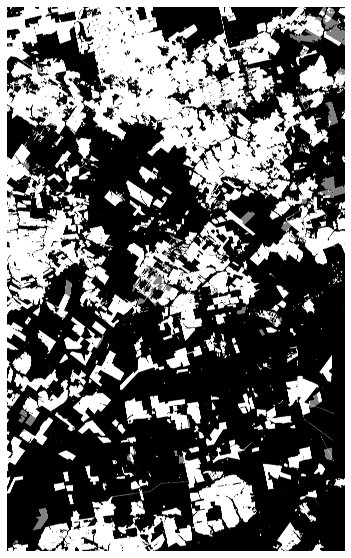

In [63]:
fig1 = plt.figure(figsize=(10,10))
plt.imshow(label_mask, cmap = plt.cm.gray)
plt.axis('off')
plt.savefig('output/figures/Para prediction probability.png', dpi=150, bbox_inches='tight')

In [64]:
if issubclass(type(dataset), MultipleDates):
    label_mask = np.squeeze(label_mask)

In [65]:
mean_prob.shape

(16795, 10420)

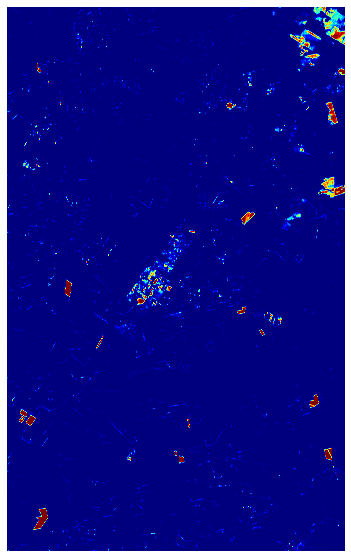

In [66]:
mean_prob = mean_prob.copy()
mean_prob[label_mask == 2] = 0
fig1 = plt.figure(figsize=(10,10))
plt.imshow(mean_prob, cmap = 'jet')
plt.axis('off')
plt.savefig('output/figures/Para prediction probability.png', dpi=150, bbox_inches='tight')

In [67]:
# print(np.unique(label_mask, return_counts=True))
print(label_mask.shape)

(16795, 10420)


In [68]:
label_test = label_mask[mask_amazon_ts == 1]
mean_prob_test = mean_prob[mask_amazon_ts == 1]
mean_prob_test = mean_prob_test[label_test != 2]
label_test = label_test[label_test != 2]

print(label_test.shape)
print(np.unique(label_test, return_counts=True))

(44657480,)
(array([0, 1], dtype=uint8), array([43783238,   874242], dtype=int64))


In [69]:
from sklearn import metrics
mAP = round(metrics.average_precision_score(label_test, 
        mean_prob_test)*100, 2)
print(mAP)

87.26


In [70]:
from icecream import ic

ic(prob_rec.shape)
prob_rec = np.transpose(prob_rec, (2, 0, 1))


ic| prob_rec.shape: (16800, 10432, 10)


In [71]:
prob_rec = np.expand_dims(prob_rec, axis = -1)

In [72]:
ic(prob_rec.shape)

ic| prob_rec.shape: (10, 16800, 10432, 1)


(10, 16800, 10432, 1)

In [73]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

epsilon = 1e-15
def show_im(im, ax, title = "", cmap = "jet"):
    im_plt = ax.imshow(im.astype(np.float32), cmap = cmap)
    plt.title(title)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im_plt, cax=cax) 

def get_mean(pred_probs):
      return np.mean(pred_probs, axis=0)
    
def get_uncertainty_var(pred_probs):
    return np.var(pred_probs, axis=0)
    
def predictive_variance(pred_probs):
    pred_var = get_uncertainty_var(pred_probs)
    pred_var = np.average(pred_var, axis = -1)
#    ic(pred_var.shape)
    return pred_var

def predictive_entropy(pred_probs):
    pred_mean = get_mean(pred_probs) # shape (patch_len, patch_len, class_n)
    pred_entropy = np.zeros((pred_mean.shape[0:2]))

    K = pred_mean.shape[-1]
    for k in range(K):
        pred_entropy = pred_entropy + pred_mean[..., k] * np.log(pred_mean[..., k] + epsilon) 
    pred_entropy = - pred_entropy / K
    return pred_entropy


def single_experiment_entropy(pred_prob):
    pred_entropy = np.zeros(pred_prob.shape[0:2])
    ic(pred_entropy.shape)
    
    K = pred_prob.shape[-1]
    for k in range(K):
        pred_entropy = pred_entropy + pred_prob[..., k] * np.log(pred_prob[..., k] + epsilon) 
    pred_entropy = - pred_entropy / K
    return pred_entropy

def mutual_information(pred_probs):
    H = predictive_entropy(pred_probs)
    
    # sum_entropy = 0
    sum_entropy = np.zeros(pred_probs.shape[1:-1])

    n = pred_probs.shape[0]
    K = pred_probs.shape[-1]
    ic(n, K)

    for i in range(n):
        for k in range(K):
            sum_entropy = sum_entropy + pred_probs[i, ..., k] * np.log(pred_probs[i, ..., k] + epsilon)

    sum_entropy = - sum_entropy / (n * K)

    MI = H - sum_entropy
    return MI


def expected_KL_divergence(pred_probs):
    pred_mean = get_mean(pred_probs) # shape (patch_len, patch_len, class_n)
    KL_divergence = np.zeros(pred_mean.shape[0:2])

    n = pred_probs.shape[0]
    K = pred_probs.shape[-1]

    for i in range(n):
        for k in range(K):
            # print(np.mean(pred_mean[..., k]), np.mean(pred_probs[i, ..., k]), np.mean(KL_divergence))
            # pdb.set_trace()
            KL_divergence += pred_mean[..., k] * np.log(pred_mean[..., k] / (pred_probs[i, ..., k] + epsilon) + epsilon)
    KL_divergence /= n
    return KL_divergence


In [74]:
ic(np.min(prob_rec), np.mean(prob_rec), np.max(prob_rec))
ic(prob_rec.shape)

ic| np.min(prob_rec): 2.2469558e-30
    np.mean(prob_rec): 0.015203303
    np.max(prob_rec): 1.0
ic| prob_rec.shape: (10, 16800, 10432, 1)


(10, 16800, 10432, 1)

In [75]:
pred_entropy = predictive_entropy(prob_rec).astype(np.float32)

pred_entropy_single = single_experiment_entropy(prob_rec[0]).astype(np.float32)

pred_var = predictive_variance(prob_rec).astype(np.float32)

MI = mutual_information(prob_rec).astype(np.float32)



ic| pred_entropy.shape: (16800, 10432)
ic| n: 10, K: 1


In [76]:
KL = expected_KL_divergence(prob_rec).astype(np.float32)

In [77]:
np.mean(KL)

0.0050963433

In [78]:

pred_entropy_to_show = pred_entropy.copy()[:label_mask.shape[0], :label_mask.shape[1]]

pred_entropy_to_show[label_mask == 2] = 0


In [79]:
ic(np.min(pred_entropy_to_show), np.mean(pred_entropy_to_show), np.max(pred_entropy_to_show))
ic(np.min(pred_entropy), np.mean(pred_entropy), np.max(pred_entropy))
ic(pred_entropy.shape, pred_entropy_to_show.shape)

ic| np.min(pred_entropy_to_show): 0.0
    np.mean(pred_entropy_to_show): 0.010480594
    np.max(pred_entropy_to_show): 0.36787948
ic| np.min(pred_entropy): 1.193959e-12
    np.mean(pred_entropy): 0.012668651
    np.max(pred_entropy): 0.36787948
ic| pred_entropy.shape: (16800, 10432)
    pred_entropy_to_show.shape: (16795, 10420)


((16800, 10432), (16795, 10420))

In [80]:
prob_rec.shape

(10, 16800, 10432, 1)

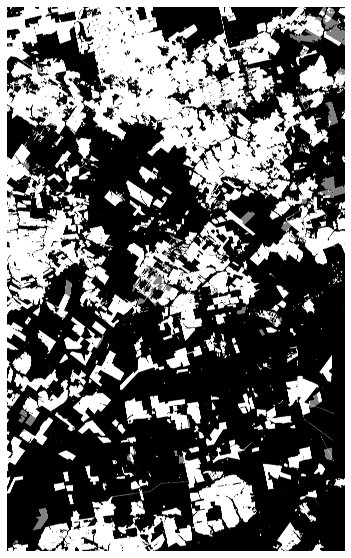

In [81]:
fig1 = plt.figure(figsize=(10,10))
plt.imshow(label_mask, cmap = plt.cm.gray)
plt.axis('off')
plt.savefig('output/figures/Para prediction probability.png', dpi=150, bbox_inches='tight')

In [82]:
# Computing error mask
# label_mask
'''
for idx in range(10):
    fig, ax = plt.subplots(figsize=(10,10))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(prob_rec[idx], cmap = 'jet')
# fig.savefig('output/figures/Para' + title_name + ' reference.png', dpi=300, bbox_inches='tight')
'''

"\nfor idx in range(10):\n    fig, ax = plt.subplots(figsize=(10,10))\n    ax.set_xticks([])\n    ax.set_yticks([])\n    ax.imshow(prob_rec[idx], cmap = 'jet')\n# fig.savefig('output/figures/Para' + title_name + ' reference.png', dpi=300, bbox_inches='tight')\n"

(-0.5, 10419.5, 16794.5, -0.5)

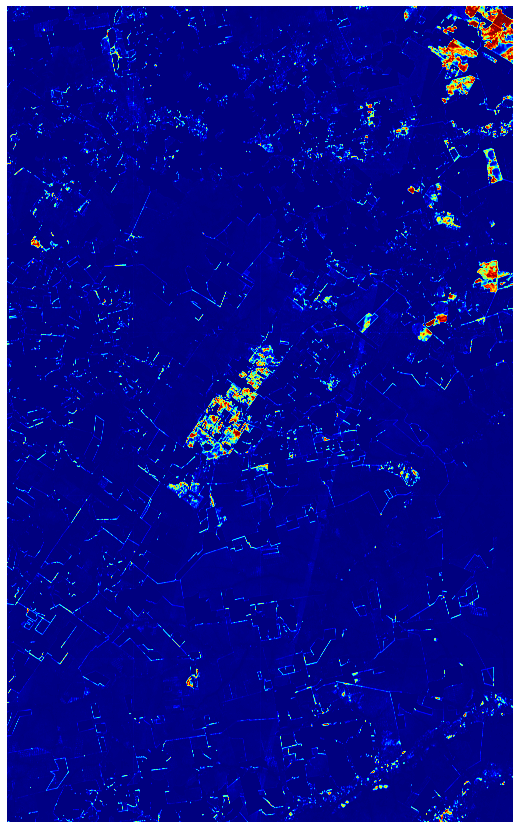

In [83]:
fig, ax = plt.subplots(figsize=(15,15))
ax.set_xticks([])
ax.set_yticks([])
ax.imshow(pred_entropy_to_show, cmap='jet')
# show_im(pred_entropy_to_show, ax, title = 'Uncertainty predictive entropy')
plt.axis('off')
#plt.savefig('output/figures/Para' + title_name + ' uncertainty predictive entropy.png', 
 #   dpi=150, bbox_inches='tight')

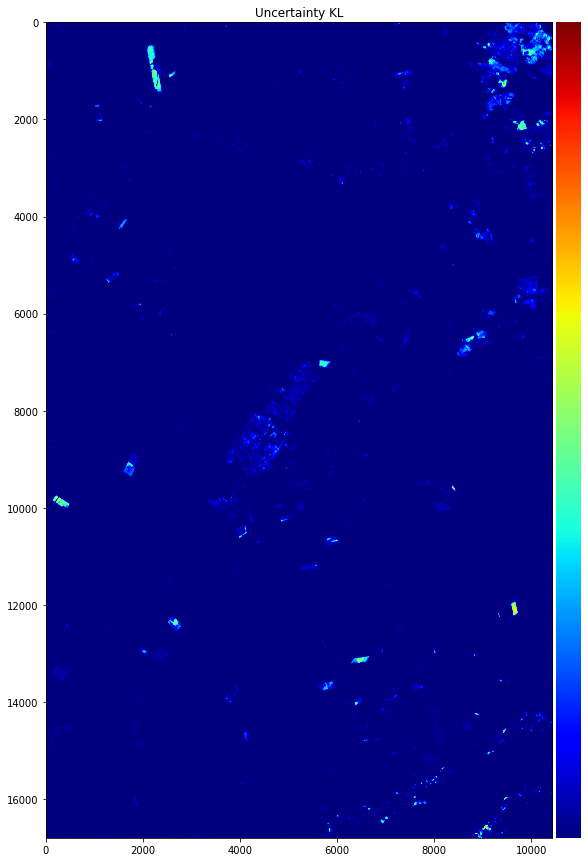

In [84]:
fig, ax = plt.subplots(1,1,figsize=(15,15))
show_im(KL, ax, title = 'Uncertainty KL')
plt.axis('off')
plt.savefig('output/figures/Para' + title_name + ' uncertainty KL.png', 
    dpi=150, bbox_inches='tight')

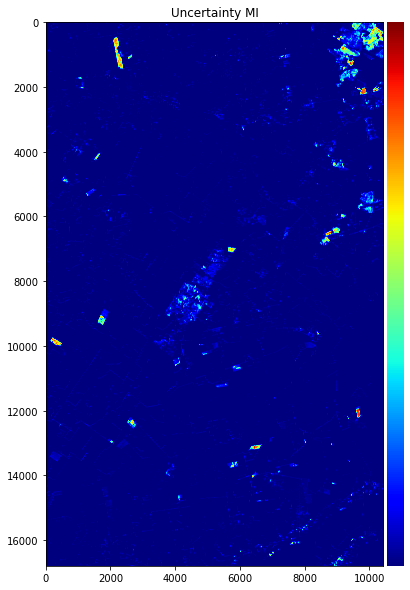

In [85]:
fig, ax = plt.subplots(1,1,figsize=(10,10))
show_im(MI, ax, title = 'Uncertainty MI')
plt.axis('off')
plt.savefig('output/figures/Para' + title_name + ' uncertainty MI.png', 
    dpi=150, bbox_inches='tight')

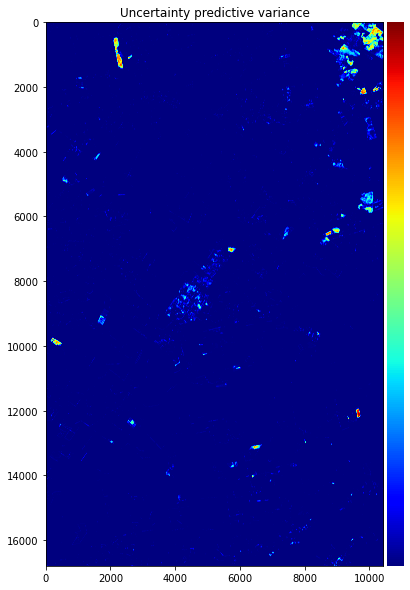

In [86]:
fig, ax = plt.subplots(1,1,figsize=(10,10))
show_im(pred_var, ax, title = 'Uncertainty predictive variance')
plt.axis('off')
plt.savefig('output/figures/Para' + title_name + ' uncertainty Predictive variance.png', 
    dpi=150, bbox_inches='tight')

In [87]:
ic(pred_entropy.shape)


ic| pred_entropy.shape: (16800, 10432)


(16800, 10432)

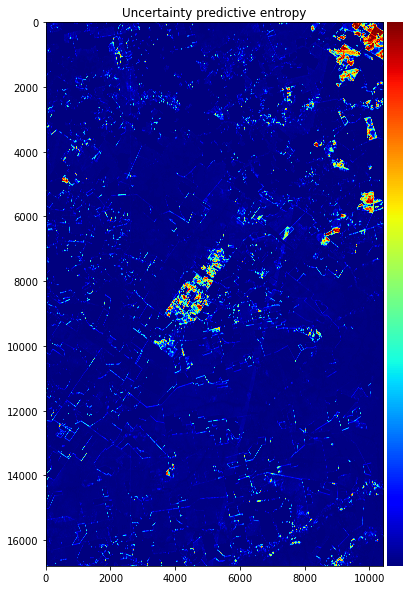

In [88]:

# pred_entropy_to_show = pred_entropy[:label_mask.shape[0], :label_mask.shape[1]].copy()

# ic(np.min(pred_entropy_to_show), np.mean(pred_entropy_to_show), np.max(pred_entropy_to_show))

# pred_entropy_to_show[label_mask == 2] = 0
fig, ax = plt.subplots(1,1,figsize=(10,10))
show_im(pred_entropy_to_show, ax, title = 'Uncertainty predictive entropy')
plt.axis('off')
plt.savefig('output/figures/Para' + title_name + ' uncertainty predictive entropy.png', 
    dpi=150, bbox_inches='tight')

In [89]:
ic(prob_rec.shape)
ic(np.min(prob_rec), np.mean(prob_rec), np.max(prob_rec))


ic| prob_rec.shape: (10, 16800, 10432, 1)
ic| np.min(prob_rec): 2.2469558e-30
    np.mean(prob_rec): 0.015203303
    np.max(prob_rec): 1.0


(2.2469558e-30, 0.015203303, 1.0)

In [90]:


'''
fig, ax = plt.subplots(1,1,figsize=(10,10))
show_im(pred_entropy_single, ax, title = 'Uncertainty predictive entropy single sample')
'''


"\nfig, ax = plt.subplots(1,1,figsize=(10,10))\nshow_im(pred_entropy_single, ax, title = 'Uncertainty predictive entropy single sample')\n"

In [91]:

'''
MI = mutual_information(prob_rec)

fig, ax = plt.subplots(1,1,figsize=(10,10))
show_im(MI, ax, title = 'Uncertainty MI')
'''


"\nMI = mutual_information(prob_rec)\n\nfig, ax = plt.subplots(1,1,figsize=(10,10))\nshow_im(MI, ax, title = 'Uncertainty MI')\n"

(array([0, 1, 2], dtype=uint8), array([70001560, 84001872, 21000468], dtype=int64))


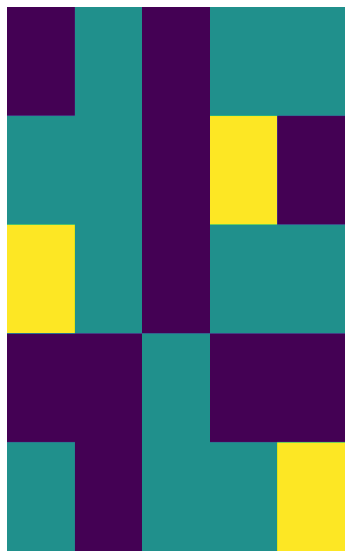

In [92]:
# mask_tr_val = test 0, train 1, val 2. 
# mask_ts = test 1.
print(np.unique(mask_tr_val, return_counts=True))
plt.figure(figsize=(10,10))
plt.imshow(mask_tr_val)
plt.axis('off')
plt.savefig('output/figures/Train val mask.png', dpi=200, bbox_inches='tight')



In [93]:
label_mask_current_deforestation = label_mask.copy()
label_mask_current_deforestation[label_mask_current_deforestation==2] = 0

In [94]:
label_mask_current_deforestation_to_show = label_mask_current_deforestation.copy()
label_mask_current_deforestation_to_show = np.abs(
        label_mask_current_deforestation_to_show - 1)
ic(np.unique(label_mask_current_deforestation_to_show, return_counts=True))

ic| np.unique(label_mask_current_deforestation_to_show, return_counts=True): (array([  0, 255], dtype=uint8), array([  2271496, 172732404], dtype=int64))


(array([  0, 255], dtype=uint8), array([  2271496, 172732404], dtype=int64))

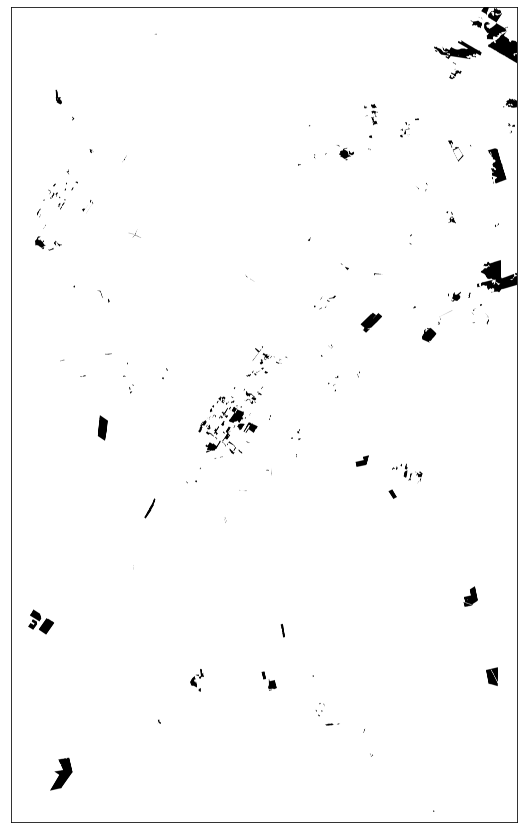

In [95]:
# Computing error mask
# label_mask

fig, ax = plt.subplots(figsize=(15,15))
ax.set_xticks([])
ax.set_yticks([])
ax.imshow(label_mask_current_deforestation_to_show, cmap = plt.cm.gray)
fig.savefig('output/figures/Para' + title_name + ' reference.png', dpi=300, bbox_inches='tight')




In [96]:


label_mask_val = label_mask[mask_tr_val == 2]
ic(label_mask_val.shape)

mean_prob_val = mean_prob[mask_tr_val == 2]

mean_prob_val = mean_prob_val[label_mask_val != 2]
label_mask_val_valid = label_mask_val[label_mask_val != 2]
ic(label_mask_val_valid.shape)



ic| label_mask_val.shape: (21000468,)
ic| label_mask_val_valid.shape: (11806421,)


(11806421,)

In [97]:
from sklearn import metrics
pos_label = 1
precision, recall, thresholds = metrics.precision_recall_curve(
            label_mask_val_valid, mean_prob_val, pos_label=pos_label)



In [98]:
fscore = (2 * precision * recall) / (precision + recall)
ix = np.nanargmax(fscore)
best_threshold = thresholds[ix]
print('Best Threshold=%f, F-Score=%.3f' % (thresholds[ix], fscore[ix]))

Best Threshold=0.602519, F-Score=0.943


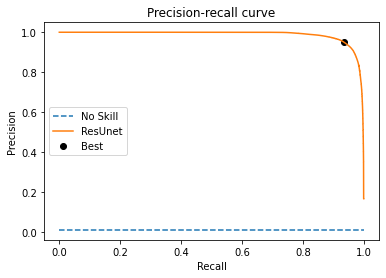

In [99]:
importlib.reload(_metrics)
_metrics.plotPrecisionRecall(label_mask_val, precision, recall, ix)
plt.savefig('output/figures/' + 'Para_prediction_recall_curve.png', dpi=150, bbox_inches='tight')

In [100]:
print(mean_prob.shape)
predicted = np.zeros_like(mean_prob)
threshold = 0.5

if predictor != Predictor.pred_entropy_single:
    predicted[mean_prob>=threshold] = 1
    predicted[mean_prob<threshold] = 0
else:
    print("Single entropy")
    predicted[prob_rec[0][...,-1][:label_mask.shape[0], :label_mask.shape[1]]>=threshold] = 1
    predicted[prob_rec[0][...,-1][:label_mask.shape[0], :label_mask.shape[1]]<threshold] = 0

print(np.unique(predicted, return_counts=True))

predicted_unpad = predicted.copy()
predicted_unpad[label_mask == 2] = 0
ic(predicted_unpad.shape, predicted.shape)
del predicted

(16795, 10420)
(array([0., 1.], dtype=float32), array([173025168,   1978732], dtype=int64))


ic| predicted_unpad.shape: (16795, 10420)
    predicted.shape: (16795, 10420)


In [101]:
threshold

0.5

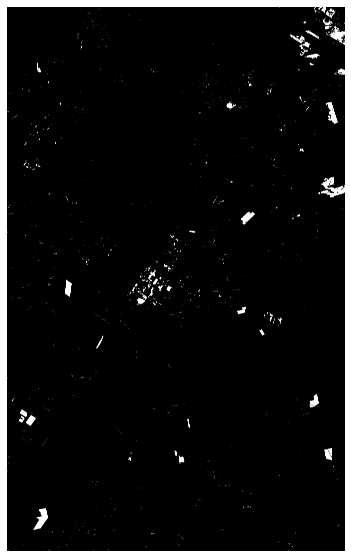

In [102]:

plt.figure(figsize=(10,10))
plt.imshow(predicted_unpad, cmap = plt.cm.gray)
plt.axis('off')
plt.savefig('output/figures/Para' + title_name + ' predicted.png', dpi=150, bbox_inches='tight')


In [103]:

# mean_prob_unpad = mean_prob[:-npad[0][1], :-npad[1][1]]

In [104]:
# mean_prob_unpad.shape

In [105]:
# ic(mask_amazon_ts.shape)
# mask_amazon_ts = mask_amazon_ts[:-npad[0][1], :-npad[1][1]]


In [106]:
# ic(mask_amazon_ts.shape, predicted_unpad.shape)
# label_mask_current_deforestation = label_mask_current_deforestation[:-npad[0][1], :-npad[1][1]]

In [107]:
# label_mask = label_mask[:-npad[0][1], :-npad[1][1]]

In [108]:
import importlib
import utils_v1
importlib.reload(utils_v1)

<module 'utils_v1' from 'd:\\Jorge\\deforestation_uncertainty\\utils_v1.py'>

In [109]:
ic(predicted_unpad.shape, label_mask_current_deforestation.shape,
    mask_amazon_ts.shape, label_mask.shape, mean_prob.shape)

ic| predicted_unpad.shape: (16795, 10420)
    label_mask_current_deforestation.shape: (16795, 10420)
    mask_amazon_ts.shape: (16795, 10420)
    label_mask.shape: (16795, 10420)
    mean_prob.shape: (16795, 10420)


((16795, 10420),
 (16795, 10420),
 (16795, 10420),
 (16795, 10420),
 (16795, 10420))

In [110]:
# test metrics
from sklearn.metrics import f1_score

predicted_test = predicted_unpad[mask_amazon_ts == 1]
label_mask_current_deforestation_test = label_mask_current_deforestation[mask_amazon_ts == 1]
label_mask_test = label_mask[mask_amazon_ts == 1]
mean_prob_test = mean_prob[mask_amazon_ts == 1]

ic(predicted_test.shape)

predicted_test = utils_v1.excludeBackgroundAreasFromTest(
        predicted_test, label_mask_test)
label_mask_current_deforestation_test = utils_v1.excludeBackgroundAreasFromTest(
        label_mask_current_deforestation_test, label_mask_test)
mean_prob_test = utils_v1.excludeBackgroundAreasFromTest(
        mean_prob_test, label_mask_test)

ic(predicted_test.shape)


ic| predicted_test.shape: (70001560,)
ic| predicted_test.shape: (44657480,)


(44657480,)

In [111]:
importlib.reload(_metrics)
removePolygons = True
if removePolygons == True:
    # remove polygons smaller than 625 px
    min_polygon_area = 625 # pixels

    predicted_unpad, label_mask = _metrics.removeSmallPolygonsForMetrics(predicted_unpad, label_mask,
        min_polygon_area)
    predicted_masked, label_masked = _metrics.getTest(predicted_unpad, label_mask, mask_amazon_ts)

    predicted_test = predicted_masked
    label_mask_current_deforestation_test = label_masked


ic| np.unique(predicted, return_counts=True): (array([0., 1.], dtype=float32), array([173025168,   1978732], dtype=int64))
    np.unique(predicted_larger_than_min_area, return_counts=True): (array([0., 1.], dtype=float32), array([173203831,   1800069], dtype=int64))
ic| np.unique(ignored_polygons, return_counts=True): (array([0., 1.], dtype=float32), array([174825237,    178663], dtype=int64))
ic| predicted.shape: (16795, 10420), label_mask.shape: (16795, 10420)
ic| predicted_masked.shape: (70001560,)
    label_masked.shape: (70001560,)
ic| np.unique(label_masked, return_counts=True): (array([0, 1, 2], dtype=uint8),
                                                  array([43734062,   862018, 25405480], dtype=int64))
ic| predicted_masked.shape: (44596080,)
    label_masked.shape: (44596080,)


In [112]:

deforestationMetricsGet = True
if deforestationMetricsGet == True:
        f1 = round(f1_score(label_mask_current_deforestation_test, predicted_test)*100, 2)
        precision = round(precision_score(label_mask_current_deforestation_test, predicted_test)*100, 2)
        recall = round(recall_score(label_mask_current_deforestation_test, predicted_test)*100, 2)
        oa = round(accuracy_score(label_mask_current_deforestation_test, predicted_test)*100, 2)
        if removePolygons == False:
                mAP = round(metrics.average_precision_score(label_mask_current_deforestation_test, 
                        mean_prob_test)*100, 2)
        else:
                '''
                # Computing metrics over the test tiles
                # mean_prob = mean_prob[:label_mask.shape[0], :label_mask.shape[1]]
                ref1 = np.ones_like(label_mask).astype(np.float32)

                ref1 [label_mask == 2] = 0
                TileMask = mask_amazon_ts * ref1
                GTTruePositives = label_mask==1

                # Metrics for th=0.5    

                Npoints = 50
                Pmax = np.max(mean_prob[GTTruePositives * TileMask ==1])
                ProbList = np.linspace(Pmax,0,Npoints)

                metrics_ = matrics_AA_recall(ProbList, mean_prob, label_mask, mask_amazon_ts, 625)
                print('Metrics th = 0.5: ', metrics_*100)
                '''
                pass


In [113]:
ic(f1, precision, recall)
# ic(f1, precision, recall)


ic| f1: 80.97, precision: 91.6, recall: 72.55


(80.97, 91.6, 72.55)

In [114]:
ic(oa)

ic| oa: 99.34


99.34

### Metrics for validation set in forest/deforestation detection

In [115]:
ic(mask_tr_val.shape)

ic| mask_tr_val.shape: (16795, 10420)


(16795, 10420)

In [116]:
predicted_val = predicted_unpad[mask_tr_val == 2]
predicted_val = predicted_val[label_mask_val != 2]

In [117]:

f1_val = round(f1_score(label_mask_val_valid, predicted_val)*100, 2)
precision_val = round(precision_score(label_mask_val_valid, predicted_val)*100, 2)
recall_val = round(recall_score(label_mask_val_valid, predicted_val)*100, 2)

mAP_val = round(metrics.average_precision_score(label_mask_val_valid, mean_prob_val)*100, 2)


ic(f1_val, precision_val, recall_val, mAP_val)

ic| f1_val: 96.32
    precision_val: 98.25
    recall_val: 94.45
    mAP_val: 98.76


(96.32, 98.25, 94.45, 98.76)

In [118]:
calculateMAPWithoutSmallPolygons = False
if calculateMAPWithoutSmallPolygons == True:
    # Computing metrics over the test tiles
    # mean_prob = mean_prob[:label_mask.shape[0], :label_mask.shape[1]]
    ref1 = np.ones_like(label_mask).astype(np.uint8)

    ref1 [label_mask == 2] = 0
    TileMask = mask_amazon_ts * ref1
    GTTruePositives = label_mask==1

    # Metrics for th=0.5    

    ProbList_05 = [0.5]

    metrics_05 = matrics_AA_recall(ProbList_05, mean_prob, label_mask, mask_amazon_ts, 625)
    print('Metrics th = 0.5: ', metrics_05*100)


In [119]:

error_mask = np.abs(predicted_unpad - label_mask_current_deforestation)
print(np.unique(error_mask, return_counts=True))


(array([0., 1.], dtype=float32), array([174165439,    838461], dtype=int64))


In [120]:
false_positive_mask = predicted_unpad - label_mask_current_deforestation
ic(false_positive_mask.shape)
ic(np.unique(false_positive_mask, return_counts=True))
# 0 class 0, 1 class 1, 2 false positive, 3 false negative
# colormap black, white, blue, red.



ic| false_positive_mask.shape: (16795, 10420)
ic| np.unique(false_positive_mask, return_counts=True): (array([-1.,  0.,  1.], dtype=float32),
                                                         array([   654944, 174165439,    183517], dtype=int64))


(array([-1.,  0.,  1.], dtype=float32),
 array([   654944, 174165439,    183517], dtype=int64))

In [121]:
ic(predicted_unpad.shape, label_mask.shape)

ic| predicted_unpad.shape: (16795, 10420)
    label_mask.shape: (16795, 10420)


((16795, 10420), (16795, 10420))

In [122]:

importlib.reload(_metrics)

prediced_unpad_to_show = predicted_unpad.copy()
prediced_unpad_to_show[label_mask == 2] = 0

error_mask_to_show = _metrics.getRgbErrorMask(prediced_unpad_to_show, 
        label_mask_current_deforestation).astype(np.uint8)
error_mask_to_show_rgb = _metrics.saveRgbErrorMask(error_mask_to_show).astype(np.uint8)
del error_mask_to_show
cv2.imwrite('output/figures/Para_error_mask_to_show_rgb.png', error_mask_to_show_rgb)

# ,
#        dim = (617, 1162)


True

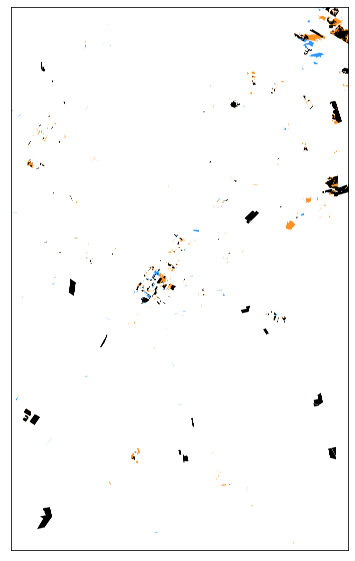

In [123]:
fig, ax = plt.subplots(figsize=(10,10))
ax.set_xticks([])
ax.set_yticks([])

ax.imshow(error_mask_to_show_rgb[...,::-1])

fig.savefig('output/figures/Para' + title_name + ' error mask color.png', dpi=300, bbox_inches='tight')


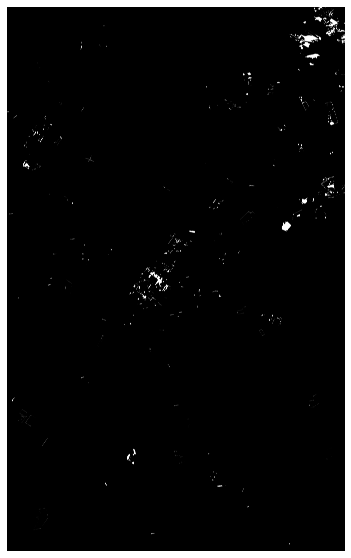

In [124]:
plt.figure(figsize=(10,10))
plt.imshow(error_mask, cmap=plt.cm.gray)
title_name = 'ResUnet'
plt.axis('off')
plt.savefig('output/figures/Para' + title_name + ' error mask.png', dpi=150, bbox_inches='tight')

In [125]:
ic(label_mask.shape)
ic(mask_amazon_ts.shape)
 
label_mask_test = utils_v1.getTestVectorFromIm(
        label_mask, mask_amazon_ts)        
ic(label_mask_test.shape)

error_mask_test = utils_v1.excludeBackgroundAreasFromTest(
        utils_v1.getTestVectorFromIm(
        error_mask, mask_amazon_ts),
        label_mask_test) 


error_mask_val = utils_v1.excludeBackgroundAreasFromTest(
        utils_v1.getTestVectorFromIm(
        error_mask, mask_tr_val, mask_return_value = 2),
        label_mask_val) 

 
ic(error_mask_test.shape)

ic| label_mask.shape: (16795, 10420)
ic| mask_amazon_ts.shape: (16795, 10420)
ic| label_mask_test.shape: (70001560,)
ic| error_mask_test.shape: (44596080,)


(44596080,)

In [126]:
# ic(pred_entropy[:-npad[0][1], :-npad[1][1]][:-npad[0][1], :-npad[1][1]].shape)

In [127]:
     

ic(pred_entropy.shape, utils_v1.unpadIm(pred_entropy, npad).shape, 
    mask_amazon_ts.shape, label_mask_test.shape)
pred_entropy_test = utils_v1.excludeBackgroundAreasFromTest(
        utils_v1.getTestVectorFromIm(
                utils_v1.unpadIm(pred_entropy, npad), mask_amazon_ts),
        label_mask_test)
  
pred_var_test = utils_v1.excludeBackgroundAreasFromTest(
        utils_v1.getTestVectorFromIm(
                utils_v1.unpadIm(pred_var, npad), mask_amazon_ts),
        label_mask_test)

MI_test = utils_v1.excludeBackgroundAreasFromTest(
        utils_v1.getTestVectorFromIm(
                utils_v1.unpadIm(MI, npad), mask_amazon_ts),
        label_mask_test)

KL_test = utils_v1.excludeBackgroundAreasFromTest(
        utils_v1.getTestVectorFromIm(
                utils_v1.unpadIm(KL, npad), mask_amazon_ts),
        label_mask_test)


ic| pred_entropy.shape: (16800, 10432)
    utils_v1.unpadIm(pred_entropy, npad).shape: (16795, 10420)
    mask_amazon_ts.shape: (16795, 10420)
    label_mask_test.shape: (70001560,)


In [128]:
pred_entropy_val = utils_v1.excludeBackgroundAreasFromTest(
        utils_v1.getTestVectorFromIm(
                utils_v1.unpadIm(pred_entropy, npad), mask_tr_val, mask_return_value = 2),
        label_mask_val)

pred_var_val = utils_v1.excludeBackgroundAreasFromTest(
        utils_v1.getTestVectorFromIm(
                utils_v1.unpadIm(pred_var, npad), mask_tr_val, mask_return_value = 2),
        label_mask_val)

MI_val = utils_v1.excludeBackgroundAreasFromTest(
        utils_v1.getTestVectorFromIm(
                utils_v1.unpadIm(MI, npad), mask_tr_val, mask_return_value = 2),
        label_mask_val)

KL_val = utils_v1.excludeBackgroundAreasFromTest(
        utils_v1.getTestVectorFromIm(
                utils_v1.unpadIm(KL, npad), mask_tr_val, mask_return_value = 2),
        label_mask_val)


In [129]:
pred_entropy_single_test = utils_v1.excludeBackgroundAreasFromTest(
        utils_v1.getTestVectorFromIm(
                utils_v1.unpadIm(pred_entropy_single, npad), mask_amazon_ts),
        label_mask_test)

pred_entropy_single_val = utils_v1.excludeBackgroundAreasFromTest(
        utils_v1.getTestVectorFromIm(
                utils_v1.unpadIm(pred_entropy_single, npad), mask_tr_val, mask_return_value = 2),
        label_mask_val)

        

In [130]:
# dataset.previewLims1 = np.array([2200, 3200, 6900, 7900])
# dataset.previewLims2 = np.array([500, 1500, 3500, 4500])
# dataset.previewBands = [2, 1, 0] 

In [131]:


# dataset.previewLims1 = np.array([7600, 8600, 4500, 5500])
# dataset.previewLims1 = np.array([12200, 13200, 200, 1200])
# dataset.previewLims1 = np.array([11800, 12800, 9000, 10000])

# dataset.previewLims1 = np.array([11500, 12500, 9000, 10000])

# dataset.previewLims2 = np.array([5000, 6000, 9500, 10500])

ic(dataset.previewLims1, dataset.previewLims2)
lims = dataset.previewLims1
ic(np.unique(mask_amazon_ts[lims[0]:lims[1], lims[2]:lims[3]], return_counts=True))
lims = dataset.previewLims2
ic(np.unique(mask_amazon_ts[lims[0]:lims[1], lims[2]:lims[3]]))
ic(mask_amazon_ts.shape)


ic| dataset.previewLims1: array([11500, 12500,  9000, 10000])
    dataset.previewLims2: array([ 5000,  6000,  9500, 10500])
ic| np.unique(mask_amazon_ts[lims[0]:lims[1], lims[2]:lims[3]], return_counts=True): (array([1], dtype=uint8), array([1000000], dtype=int64))
ic| np.unique(mask_amazon_ts[lims[0]:lims[1], lims[2]:lims[3]]): array([1], dtype=uint8)
ic| mask_amazon_ts.shape: (16795, 10420)


(16795, 10420)

In [132]:
uncertainty_vlims = [np.min(pred_entropy_to_show), np.max(pred_entropy_to_show)]


ic| dataset.previewLims1: array([11500, 12500,  9000, 10000])
    dataset.previewLims2: array([ 5000,  6000,  9500, 10500])
ic| np.unique(mask_amazon_ts[lims[0]:lims[1], lims[2]:lims[3]]): array([1], dtype=uint8)
ic| np.unique(mask_amazon_ts[lims[0]:lims[1], lims[2]:lims[3]], return_counts=True): (array([1], dtype=uint8), array([920000], dtype=int64))


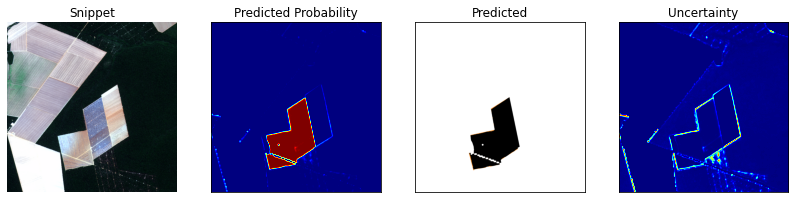

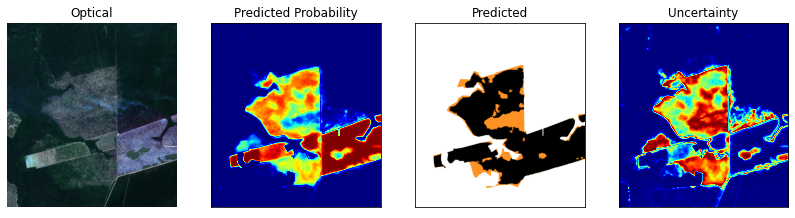

In [133]:


plotCropSampleFlag = True
if plotCropSampleFlag == True:
        importlib.reload(_metrics)
        # import matplotlib
        # customCmap = matplotlib.colors.ListedColormap(['black', 'red'])
        ic(dataset.previewLims1, dataset.previewLims2)
        lims = dataset.previewLims1
        ic(np.unique(mask_amazon_ts[lims[0]:lims[1], lims[2]:lims[3]]))
        lims = dataset.previewLims2
        ic(np.unique(mask_amazon_ts[lims[0]:lims[1], lims[2]:lims[3]], return_counts=True))

        _plt.plotCropSample4(image_stack[...,dataset.previewBands], mean_prob, 
                error_mask_to_show_rgb[...,::-1], pred_entropy_to_show, 
                lims = dataset.previewLims1, 
                titles = ['Snippet', 'Predicted Probability', 'Predicted', 'Uncertainty'],
                cmaps = [plt.cm.gray, 'jet', plt.cm.gray, 'jet'],
                maskBackground = [False, True, False, True],
                invertMask = [False, False, False, False], uncertainty_vlims = uncertainty_vlims)
        plt.savefig('output/figures/' + dataset.__class__.__name__ + 'PredictSampleUncertainty1.png', dpi=150, bbox_inches='tight')

        _plt.plotCropSample4(image_stack[...,dataset.previewBands], mean_prob, 
                error_mask_to_show_rgb[...,::-1], pred_entropy_to_show, 
                lims = dataset.previewLims2, 
                titles = ['Optical', 'Predicted Probability', 'Predicted', 'Uncertainty'],
                cmaps = [plt.cm.gray, 'jet', plt.cm.gray, 'jet'],
                maskBackground = [False, True, False, True],
                invertMask = [False, False, False, False], uncertainty_vlims = uncertainty_vlims)
        plt.savefig('output/figures/' + dataset.__class__.__name__ + 'PredictSampleUncertainty2.png', dpi=150, bbox_inches='tight')

In [134]:

if predictor == Predictor.pred_var:
    uncertainty = pred_var_test
    uncertainty_val = pred_var_val
    plot_lims = [[0, 0.38], [0, 2500]]
    title_name = 'Predictive Variance'
    best_threshold = 0.2
elif predictor == Predictor.MI:
    uncertainty = MI_test
    uncertainty_val = MI_val
    plot_lims = [[0, 0.38], [0, 2500]]
    title_name = 'Mutual Information'
    best_threshold = 0.2
elif predictor == Predictor.pred_entropy:
    uncertainty = pred_entropy_test
    uncertainty_val = pred_entropy_val
    plot_lims = [[0, 0.38], [0, 2500]]
    title_name = 'Predictive Entropy'
    best_threshold = 0.287
elif predictor == Predictor.KL:
    uncertainty = KL_test
    uncertainty_val = KL_val
    plot_lims = [[0, 0.38], [0, 2500]]
    title_name = 'Predictive Entropy'
    best_threshold = 0.287

elif predictor == Predictor.pred_entropy_single:
    uncertainty = pred_entropy_single_test
    uncertainty_val = pred_entropy_single_val
    plot_lims = [[0, 0.38], [0, 2500]]
    title_name = 'Predictive Entropy Single'
    best_threshold = 0.287


In [135]:
ic(np.min(uncertainty), np.mean(uncertainty), np.max(uncertainty))
ic(np.min(pred_entropy), np.mean(pred_entropy), np.max(pred_entropy))


ic| np.min(uncertainty): 1.1724405e-08
    np.mean(uncertainty): 0.015282347
    np.max(uncertainty): 0.36787948
ic| np.min(pred_entropy): 1.193959e-12
    np.mean(pred_entropy): 0.012668651
    np.max(pred_entropy): 0.36787948


(1.193959e-12, 0.012668651, 0.36787948)

In [136]:

y_test = error_mask_test
y_val = error_mask_val

ic(y_test.shape, uncertainty.shape)
pos_label = 1
ROCmode = 'val'
if ROCmode == 'test':
    fpr, tpr, thresholds = metrics.roc_curve(y_test, uncertainty, pos_label=pos_label)
elif ROCmode == 'val':
    fpr, tpr, thresholds = metrics.roc_curve(y_val, uncertainty_val, pos_label=pos_label)

roc_auc = metrics.auc(fpr, tpr)
ic(roc_auc)

ic| y_test.shape: (44596080,), uncertainty.shape: (44596080,)
ic| roc_auc: 0.9907418437501642


0.9907418437501642

Best Threshold=0.054014, G-Mean=0.967


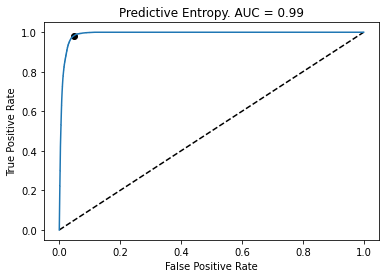

In [137]:
importlib.reload(_metrics)
plt.figure()
_metrics.plotAUC(fpr, tpr, roc_auc, modelId = title_name)
ix, best_threshold_uncertainty = _metrics.getBestThresholdGMean(fpr, tpr, thresholds)
# ix, best_threshold_uncertainty = _metrics.getBestThresholdJStatistic(fpr, tpr, thresholds)

_metrics.plotBestThreshold(fpr, tpr, ix)
plt.savefig(figures_path + title_name + ' roc_curve.png', dpi=200)

In [138]:
np.set_printoptions(suppress=False)
ic(best_threshold_uncertainty)
np.set_printoptions(suppress=True)


ic| best_threshold_uncertainty: 0.05401405


In [139]:
# best_threshold_uncertainty = 0.262948
# best_threshold_uncertainty = 0.08329400420188904

In [140]:
# threshold = 0.003254
y_pred_thresholded = np.zeros_like(uncertainty)
y_pred_thresholded[uncertainty >= best_threshold_uncertainty] = 1


In [141]:
metrics_error_detection = False
if metrics_error_detection == True:
    f1 = round(f1_score(error_mask_test, y_pred_thresholded)*100, 2)
    precision = round(metrics.precision_score(error_mask_test, y_pred_thresholded)*100, 2)
    recall = round(metrics.recall_score(error_mask_test, y_pred_thresholded)*100, 2)
    ic(f1, precision, recall)

    cm = metrics.confusion_matrix(error_mask_test, y_pred_thresholded)
    print(cm)

In [142]:
if metrics_error_detection == True:

    ic(best_threshold_uncertainty)

In [143]:
if metrics_error_detection == True:

    predicted_error_mask = np.zeros(pred_entropy.shape, dtype = np.uint8)
    predicted_error_mask[pred_entropy>=best_threshold_uncertainty] = 1
    predicted_error_mask = utils_v1.unpadIm(predicted_error_mask, npad)

    predicted_error_mask[label_mask == 2] = 0

In [144]:
if metrics_error_detection == True:

    # ic(np.unique(predicted_error_mask, return_counts=True))
    # ic(np.unique(error_mask, return_counts=True))
    predicted_error_mask_to_show = predicted_error_mask.copy()
    predicted_error_mask_to_show = np.abs(1 - predicted_error_mask_to_show)
    predicted_error_mask_to_show = predicted_error_mask_to_show.astype(np.uint8)*255
    predicted_error_mask_to_show = np.repeat(
        np.expand_dims(predicted_error_mask_to_show, axis=-1),
        3, axis = -1)
    fig, ax = plt.subplots(figsize=(15,15))
    ax.set_xticks([])
    ax.set_yticks([])

    ax.imshow(predicted_error_mask_to_show)


    title_name = 'ResUnet'
    fig.savefig('output/figures/Para' + title_name + 'predicted error mask.png', dpi=300, bbox_inches='tight')


In [145]:
if metrics_error_detection == True:

    predicted_error_mask_forest = predicted_error_mask.copy()
    predicted_error_mask_forest[predicted_unpad == 1] = 0
    ic(np.unique(predicted_unpad, return_counts=True))
    ic(np.unique(predicted_error_mask_forest, return_counts=True))

    plt.figure(figsize=(10,10))
    plt.imshow(predicted_error_mask, cmap=plt.cm.gray)
    title_name = 'ResUnet'
    plt.axis('off')
    plt.savefig('output/figures/Para' + title_name + 'predicted error mask forest.png', dpi=150, bbox_inches='tight')


In [146]:
if metrics_error_detection == True:

        importlib.reload(_metrics)
        _metrics.plotConfusionMatrix(cm)
        plt.savefig(figures_path + title_name + ' confusion matrix ROC threshold.png', 
                dpi=200, bbox_inches='tight')

In [147]:
label_mask_current_deforestation_test = utils_v1.excludeBackgroundAreasFromTest(
        utils_v1.getTestVectorFromIm(
                label_mask_current_deforestation, mask_amazon_ts),
        label_mask_test)

predicted_test = utils_v1.excludeBackgroundAreasFromTest(
        utils_v1.getTestVectorFromIm(
                predicted_unpad, mask_amazon_ts),
        label_mask_test)
        


Get precision-recall threshold

In [148]:
precision, recall, thresholds = metrics.precision_recall_curve(
            y_val, uncertainty_val, pos_label=pos_label)



In [149]:
ic(thresholds)

ic| thresholds: array([0.01347699, 0.01347706, 0.01347711, ..., 0.36787942, 0.36787945,
                       0.36787948], dtype=float32)


array([0.01347699, 0.01347706, 0.01347711, ..., 0.36787942, 0.36787945,
       0.36787948], dtype=float32)

In [150]:
fscore = (2 * precision * recall) / (precision + recall)
ix = np.nanargmax(fscore)
best_threshold_uncertainty = thresholds[ix]
print('Best Threshold=%f, F-Score=%.3f' % (thresholds[ix], fscore[ix]))

Best Threshold=0.345894, F-Score=0.214


C:\Users\jchamorro\AppData\Local\Temp\ipykernel_11284\3129774117.py:1: RuntimeWarning: invalid value encountered in true_divide
  fscore = (2 * precision * recall) / (precision + recall)


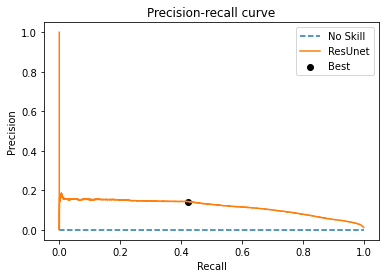

In [151]:
importlib.reload(_metrics)
_metrics.plotPrecisionRecall(y_val, precision, recall, ix)
plt.savefig('output/figures/' + 'Para' + 'prediction_recall_curve.png', dpi=150, bbox_inches='tight')

In [152]:
'''
# Metrics for th=0.5    
ProbList_05 = [0.5]

metrics_05 = matrics_AA_recall(ProbList_05, mean_prob, label_mask, mask_amazon_ts, 625)
print('Metrics th = 0.5: ', metrics_05*100)
'''


"\n# Metrics for th=0.5    \nProbList_05 = [0.5]\n\nmetrics_05 = matrics_AA_recall(ProbList_05, mean_prob, label_mask, mask_amazon_ts, 625)\nprint('Metrics th = 0.5: ', metrics_05*100)\n"

In [153]:
ic(np.min(uncertainty), np.average(uncertainty), np.max(uncertainty))

ic| np.min(uncertainty): 1.1724405e-08
    np.average(uncertainty): 0.015282347
    np.max(uncertainty): 0.36787948


(1.1724405e-08, 0.015282347, 0.36787948)

In [154]:
# plt.hist(uncertainty)

In [155]:
ic(uncertainty.dtype, label_mask_current_deforestation_test.dtype, predicted_test.dtype)

ic| uncertainty.dtype: dtype('float32')
    label_mask_current_deforestation_test.dtype: dtype('uint8')
    predicted_test.dtype: dtype('float32')


(dtype('float32'), dtype('uint8'), dtype('float32'))

In [156]:
ic(uncertainty.shape, label_mask_current_deforestation_test.shape)
ic(np.unique(label_mask_current_deforestation_test))

ic| uncertainty.shape: (44596080,)
    label_mask_current_deforestation_test.shape: (44596080,)
ic| np.unique(label_mask_current_deforestation_test): array([0, 1], dtype=uint8)


array([0, 1], dtype=uint8)

In [157]:
ic(np.min(uncertainty), np.mean(uncertainty), np.max(uncertainty))

ic| np.min(uncertainty): 1.1724405e-08
    np.mean(uncertainty): 0.015282347
    np.max(uncertainty): 0.36787948


(1.1724405e-08, 0.015282347, 0.36787948)

In [158]:
importlib.reload(_metrics)

threshold_uncertainty = 0.15

predicted_thresholded = np.zeros_like(uncertainty).astype(np.int8)
predicted_thresholded[uncertainty >= threshold_uncertainty] = 1
predicted_thresholded = predicted_thresholded.astype(np.uint8)
ic(predicted_thresholded.shape)


ic| predicted_thresholded.shape: (44596080,)


(44596080,)

In [159]:
ic(np.unique(predicted_thresholded, return_counts=True),
    np.unique(label_mask, return_counts=True),
    np.unique(mask_amazon_ts, return_counts=True))



ic| np.unique(predicted_thresholded, return_counts=True): (array([0, 1], dtype=uint8), array([43108536,  1487544], dtype=int64))
    np.unique(label_mask, return_counts=True): (array([0, 1, 2], dtype=uint8),
                                                array([109857053,   2232076,  62914771], dtype=int64))
    np.unique(mask_amazon_ts, return_counts=True): (array([0, 1], dtype=uint8), array([105002340,  70001560], dtype=int64))


((array([0, 1], dtype=uint8), array([43108536,  1487544], dtype=int64)),
 (array([0, 1, 2], dtype=uint8),
  array([109857053,   2232076,  62914771], dtype=int64)),
 (array([0, 1], dtype=uint8), array([105002340,  70001560], dtype=int64)))

In [160]:
def getUncertaintyPercentageFromTest(uncertainty_mask, 
        label_mask, mask_test):
    total_test_area = mask_test.copy()
    total_test_area[label_mask == 2] = 0

    percentage = np.count_nonzero(uncertainty_mask.flatten()) / np.count_nonzero(total_test_area.flatten())
    return total_test_area, percentage

total_test_area, percentage = getUncertaintyPercentageFromTest(predicted_thresholded, 
        label_mask, mask_amazon_ts)

ic(percentage)

ic| percentage: 0.03335593621681547


0.03335593621681547

In [161]:
AA = np.count_nonzero(predicted_thresholded.flatten()) / len(label_mask_current_deforestation_test)
ic(AA)

# metrics_values = _metrics.getAA_Recall(uncertainty, 
#                 label_mask_current_deforestation_test, 
#                 predicted_test, [threshold_uncertainty])


ic| AA: 0.03335593621681547


0.03335593621681547

In [162]:
predictor

<Predictor.pred_entropy: 3>

In [163]:

importlib.reload(_metrics)

# threshold_list = [0.01, 0.015, 0.025, 0.05, 0.08, 0.1, 0.15, 0.2, 0.25, 0.27, 0.3, 0.34, 0.36]

# threshold_list = [0.005, 0.0075, 0.01, 0.015, 0.025, 0.05, 0.08, 0.1, 0.15, 0.2, 0.25, 0.27, 0.3, 0.34, 0.36, np.max(uncertainty)-0.003]
if predictor == Predictor.pred_entropy:
        threshold_list = [0.0025, 0.005, 0.0075, 0.01, 0.015, 0.025, 0.05, 0.08, 0.1, 0.15, 0.2, 0.225, 
                0.25, 0.27, 0.3, 0.34, 0.36, np.max(uncertainty)-0.003, np.max(uncertainty)-0.0015]
elif predictor == Predictor.pred_var:
        threshold_list = [0.0025, 0.005, 0.0075, 0.01, 0.015, 0.025, 0.05, 0.08, 0.1, 0.15, 0.2, 0.225, 
                0.25, 0.27, 0.3, 0.34, 0.36]
        threshold_list = [x*0.13/0.36 for x in threshold_list] + [np.max(uncertainty)-0.0015, np.max(uncertainty)-0.0008]
elif predictor == Predictor.MI:
        threshold_list = [0.0025, 0.005, 0.0075, 0.01, 0.015, 0.025, 0.05, 0.08, 0.1, 0.15, 0.2, 0.225, 
                0.25, 0.27, 0.3, 0.34, 0.36]
        threshold_list = [x*0.235/0.36 for x in threshold_list] + [np.max(uncertainty)-0.003, np.max(uncertainty)-0.0015]
elif predictor == Predictor.KL:
        threshold_list = [0.0025, 0.005, 0.0075, 0.01, 0.015, 0.025, 0.05, 0.08, 0.1, 0.15, 0.2, 0.225, 
                0.25, 0.27, 0.3, 0.34, 0.36]
        threshold_list = [x*1.0/0.36 for x in threshold_list] + [np.max(uncertainty)-0.006, np.max(uncertainty)-0.003]
                
        # threshold_list = np.linspace(np.min(uncertainty) + 0.0015, np.max(uncertainty) - 0.0015, 19)
print(threshold_list)
loadThresholdMetrics = False
if loadThresholdMetrics == False:
        # threshold_list = [0.1]
        # y_test
        ic(uncertainty.shape, label_mask_current_deforestation_test.shape)
        importlib.reload(_metrics)

        metrics_values = _metrics.getAA_Recall(uncertainty, 
                label_mask_current_deforestation_test, 
                predicted_test, threshold_list)

        # ic(metrics_values)


ic| uncertainty.shape: (44596080,)
    label_mask_current_deforestation_test.shape: (44596080,)


[0.0025, 0.005, 0.0075, 0.01, 0.015, 0.025, 0.05, 0.08, 0.1, 0.15, 0.2, 0.225, 0.25, 0.27, 0.3, 0.34, 0.36, 0.3648794801235199, 0.3663794801235199]
threshold 0.0025
(20214803,) (20214803,)


ic| label_current_deforestation_test_classified_incorrect.shape: (24381277,)
    predicted_test_classified_incorrect.shape: (24381277,)


cm_correct [[20048881     1573]
 [     207   164142]]


ic| TP_H + FN_H + FP_H + TN_H: 24381277
    len(label_mask_current_deforestation_test): 44596080
ic| TP_H + FN_H + FP_H + TN_H: 24381277
    len(label_mask_current_deforestation_test): 44596080


cm_incorrect [[23627833    55775]
 [  236386   461283]]
[0.9905078  0.99874049 0.19041598 0.54671346 0.89213009 0.66117744]
threshold 0.005
(33772613,) (33772613,)


ic| label_current_deforestation_test_classified_incorrect.shape: (10823467,)
    predicted_test_classified_incorrect.shape: (10823467,)


cm_correct [[33572906     3079]
 [     404   196224]]


ic| TP_H + FN_H + FP_H + TN_H: 10823467
    len(label_mask_current_deforestation_test): 44596080
ic| TP_H + FN_H + FP_H + TN_H: 10823467
    len(label_mask_current_deforestation_test): 44596080


cm_incorrect [[10103808    54269]
 [  236189   429201]]
[0.98455116 0.99794536 0.2276333  0.24269996 0.88775105 0.64503675]
threshold 0.0075
(37587231,) (37587231,)


ic| label_current_deforestation_test_classified_incorrect.shape: (7008849,)
    predicted_test_classified_incorrect.shape: (7008849,)


cm_correct [[37366769     3954]
 [     646   215862]]


ic| TP_H + FN_H + FP_H + TN_H: 7008849
    len(label_mask_current_deforestation_test): 44596080
ic| TP_H + FN_H + FP_H + TN_H: 7008849
    len(label_mask_current_deforestation_test): 44596080


cm_incorrect [[6309945   53394]
 [ 235947  409563]]
[0.98201223 0.99701628 0.25041472 0.15716289 0.88466747 0.63447971]
threshold 0.01
(38945300,) (38945300,)


ic| label_current_deforestation_test_classified_incorrect.shape: (5650780,)
    predicted_test_classified_incorrect.shape: (5650780,)


cm_correct [[38709304     4589]
 [    1191   230216]]


ic| TP_H + FN_H + FP_H + TN_H: 5650780
    len(label_mask_current_deforestation_test): 44596080
ic| TP_H + FN_H + FP_H + TN_H: 5650780
    len(label_mask_current_deforestation_test): 44596080


cm_incorrect [[4967410   52759]
 [ 235402  395209]]
[0.98045612 0.99485322 0.26706635 0.12671024 0.88222596 0.62670807]
threshold 0.015
(40088833,) (40088833,)


ic| label_current_deforestation_test_classified_incorrect.shape: (4507247,)
    predicted_test_classified_incorrect.shape: (4507247,)


cm_correct [[39830927     5430]
 [    2539   249937]]


ic| TP_H + FN_H + FP_H + TN_H: 4507247
    len(label_mask_current_deforestation_test): 44596080
ic| TP_H + FN_H + FP_H + TN_H: 4507247
    len(label_mask_current_deforestation_test): 44596080


cm_incorrect [[3845787   51918]
 [ 234054  375488]]
[0.97873649 0.9899436  0.28994406 0.10106823 0.87852768 0.61601662]
threshold 0.025
(41060367,) (41060367,)


ic| label_current_deforestation_test_classified_incorrect.shape: (3535713,)
    predicted_test_classified_incorrect.shape: (3535713,)


cm_correct [[40771445     6612]
 [    4297   278013]]


ic| TP_H + FN_H + FP_H + TN_H: 3535713
    len(label_mask_current_deforestation_test): 44596080
ic| TP_H + FN_H + FP_H + TN_H: 3535713
    len(label_mask_current_deforestation_test): 44596080


cm_incorrect [[2905269   50736]
 [ 232296  347412]]
[0.97676943 0.98477914 0.32251415 0.07928304 0.87257    0.59928792]
threshold 0.05
(41989590,) (41989590,)


ic| label_current_deforestation_test_classified_incorrect.shape: (2606490,)
    predicted_test_classified_incorrect.shape: (2606490,)


cm_correct [[41655133     8231]
 [    9150   317076]]


ic| TP_H + FN_H + FP_H + TN_H: 2606490
    len(label_mask_current_deforestation_test): 44596080
ic| TP_H + FN_H + FP_H + TN_H: 2606490
    len(label_mask_current_deforestation_test): 44596080


cm_incorrect [[2021581   49117]
 [ 227443  308349]]
[0.97469775 0.97195196 0.36782991 0.05844662 0.86259672 0.57550131]
threshold 0.08
(42477417,) (42477417,)


ic| label_current_deforestation_test_classified_incorrect.shape: (2118663,)
    predicted_test_classified_incorrect.shape: (2118663,)


cm_correct [[42106420     9649]
 [   16564   344784]]


ic| TP_H + FN_H + FP_H + TN_H: 2118663
    len(label_mask_current_deforestation_test): 44596080
ic| TP_H + FN_H + FP_H + TN_H: 2118663
    len(label_mask_current_deforestation_test): 44596080


cm_incorrect [[1570294   47699]
 [ 220029  280641]]
[0.97277624 0.95416053 0.39997309 0.04750783 0.85472681 0.56053089]
threshold 0.1
(42699024,) (42699024,)


ic| label_current_deforestation_test_classified_incorrect.shape: (1897056,)
    predicted_test_classified_incorrect.shape: (1897056,)


cm_correct [[42305923    10593]
 [   21848   360660]]


ic| TP_H + FN_H + FP_H + TN_H: 1897056
    len(label_mask_current_deforestation_test): 44596080
ic| TP_H + FN_H + FP_H + TN_H: 1897056
    len(label_mask_current_deforestation_test): 44596080


cm_incorrect [[1370791   46755]
 [ 214745  264765]]
[0.9714669  0.94288224 0.41839034 0.04253863 0.84991333 0.55215741]
threshold 0.15
(43108536,) (43108536,)


ic| label_current_deforestation_test_classified_incorrect.shape: (1487544,)
    predicted_test_classified_incorrect.shape: (1487544,)
ic| TP_H + FN_H + FP_H +

cm_correct [[42659672    14381]
 [   33568   400915]]
cm_incorrect [[1017042   42967]
 [ 203025  224510]]


 TN_H: 1487544
    len(label_mask_current_deforestation_test): 44596080
ic| TP_H + FN_H + FP_H + TN_H: 1487544
    len(label_mask_current_deforestation_test): 44596080


[0.96537169 0.92274036 0.4650889  0.03335594 0.83936189 0.5251266 ]
threshold 0.2
(43432532,) (43432532,)


ic| label_current_deforestation_test_classified_incorrect.shape: (1163548,)
    predicted_test_classified_incorrect.shape: (1163548,)
ic| TP_H + FN_H + FP_H + TN_H: 1163548
    len(label_mask_current_deforestation_test): 44596080
ic| TP_H + FN_H + FP_H + TN_H: 1163548
    len(label_mask_current_deforestation_test): 44596080


cm_correct [[42911325    20280]
 [   47381   453546]]
cm_incorrect [[765389  37068]
 [189212 171879]]
[0.95719948 0.90541336 0.52614447 0.02609081 0.82259616 0.47599912]
threshold 0.225
(43580030,) (43580030,)


ic| label_current_deforestation_test_classified_incorrect.shape: (1016050,)
    predicted_test_classified_incorrect.shape: (1016050,)
ic| TP_H + FN_H + FP_H + TN_H: 1016050
    len(label_mask_current_deforestation_test): 44596080
ic| TP_H + FN_H + FP_H + TN_H: 1016050
    len(label_mask_current_deforestation_test): 44596080


cm_correct [[43017143    23792]
 [   56759   482336]]
cm_incorrect [[659571  33556]
 [179834 143089]]
[0.95299213 0.89471429 0.55954284 0.02278339 0.81003708 0.44310563]
threshold 0.25
(43720368,) (43720368,)


ic| label_current_deforestation_test_classified_incorrect.shape: (875712,)
    predicted_test_classified_incorrect.shape: (875712,)
ic| TP_H + FN_H + FP_H + TN_H: 875712
    len(label_mask_current_deforestation_test): 44596080
ic| TP_H + FN_H + FP_H + TN_H: 875712
    len(label_mask_current_deforestation_test): 44596080


cm_correct [[43115393    27784]
 [   68962   508229]]
cm_incorrect [[561321  29564]
 [167631 117196]]
[0.94816544 0.88052135 0.5895805  0.01963652 0.79855546 0.4114638 ]
threshold 0.27
(43828326,) (43828326,)


ic| label_current_deforestation_test_classified_incorrect.shape: (767754,)
    predicted_test_classified_incorrect.shape: (767754,)
ic| TP_H + FN_H + FP_H + TN_H: 767754
    len(label_mask_current_deforestation_test): 44596080
ic| TP_H + FN_H + FP_H + TN_H: 767754
    len(label_mask_current_deforestation_test): 44596080


cm_correct [[43188621    31092]
 [   78850   529763]]
cm_incorrect [[488093  26256]
 [157743  95662]]
[0.94456321 0.87044312 0.61456141 0.01721573 0.78464214 0.37750636]
threshold 0.3
(43986754,) (43986754,)


ic| label_current_deforestation_test_classified_incorrect.shape: (609326,)
    predicted_test_classified_incorrect.shape: (609326,)
ic| TP_H + FN_H + FP_H + TN_H: 609326
    len(label_mask_current_deforestation_test): 44596080
ic| TP_H + FN_H + FP_H + TN_H: 609326
    len(label_mask_current_deforestation_test): 44596080


cm_correct [[43289199    37808]
 [   94525   565222]]
cm_incorrect [[387515  19540]
 [142068  60203]]
[0.93730329 0.85672538 0.65569628 0.01366322 0.75496282 0.29763535]
threshold 0.34
(44215970,) (44215970,)


ic| label_current_deforestation_test_classified_incorrect.shape: (380110,)
    predicted_test_classified_incorrect.shape: (380110,)
ic| TP_H + FN_H + FP_H + TN_H: 380110
    len(label_mask_current_deforestation_test): 44596080
ic| TP_H + FN_H + FP_H + TN_H: 380110
    len(label_mask_current_deforestation_test): 44596080


cm_correct [[43421668    54514]
 [  123057   616731]]
cm_incorrect [[255046   2834]
 [113536   8694]]
[0.91878673 0.8336591  0.71545026 0.00852339 0.75416378 0.0711282 ]
threshold 0.36
(44392588,) (44392588,)


ic| label_current_deforestation_test_classified_incorrect.shape: (203492,)
    predicted_test_classified_incorrect.shape: (203492,)
d:\Jorge\deforestation_uncertainty\src\metrics.py:299: RuntimeWarning: invalid value encountered in longlong_scalars
  precision_H = TP_H / (TP_H + FP_H)
ic| TP_H + FN_H + FP_H + TN_H: 203492
    len(label_mask_current_deforestation_test): 44596080
ic| TP_H + FN_H + FP_H + TN_H: 203492
    len(label_mask_current_deforestation_test): 44596080


cm_correct [[43535678    57348]
 [  174137   625425]]
cm_incorrect [[141036      0]
 [ 62456      0]]
[0.91600722 0.78220951 0.72553589 0.004563          nan 0.        ]
threshold 0.3648794801235199
(44472561,) (44472561,)


ic| label_current_deforestation_test_classified_incorrect.shape: (123519,)
    predicted_test_classified_incorrect.shape: (123519,)
d:\Jorge\deforestation_uncertainty\src\metrics.py:299: RuntimeWarning: invalid value encountered in longlong_scalars
  precision_H = TP_H / (TP_H + FP_H)
ic| TP_H + FN_H + FP_H + TN_H: 123519
    len(label_mask_current_deforestation_test): 44596080
ic| TP_H + FN_H + FP_H + TN_H: 123519
    len(label_mask_current_deforestation_test): 44596080


cm_correct [[43591233    57348]
 [  198555   625425]]
cm_incorrect [[85481     0]
 [38038     0]]
[0.91600722 0.75902935 0.72553589 0.00276973        nan 0.        ]
threshold 0.3663794801235199
(44509311,) (44509311,)


ic| label_current_deforestation_test_classified_incorrect.shape: (86769,)
    predicted_test_classified_incorrect.shape: (86769,)
d:\Jorge\deforestation_uncertainty\src\metrics.py:299: RuntimeWarning: invalid value encountered in longlong_scalars
  precision_H = TP_H / (TP_H + FP_H)
ic| TP_H + FN_H + FP_H + TN_H: 86769
    len(label_mask_current_deforestation_test): 44596080
ic| TP_H + FN_H + FP_H + TN_H: 86769
    len(label_mask_current_deforestation_test): 44596080


cm_correct [[43616797    57348]
 [  209741   625425]]
cm_incorrect [[59917     0]
 [26852     0]]
[0.91600722 0.7488631  0.72553589 0.00194566        nan 0.        ]


In [164]:

if loadThresholdMetrics == False:
        # threshold_list = [0.1]
        # y_test
        ic(uncertainty.shape, label_mask_current_deforestation_test.shape)
        importlib.reload(_metrics)

        metric_values_audited = _metrics.getUncertaintyMetricsAudited(uncertainty, 
                label_mask_current_deforestation_test, 
                predicted_test, threshold_list)

        ic(metric_values_audited)



ic| uncertainty.shape: (44596080,)
    label_mask_current_deforestation_test.shape: (44596080,)


threshold 0.0025
(44596080,) (44596080,)
cm_audited [[43732489     1573]
 [     207   861811]]
[0.9981781  0.99975987]
threshold 0.005
(44596080,) (44596080,)
cm_audited [[43730983     3079]
 [     404   861614]]
[0.9964392  0.99953133]
threshold 0.0075
(44596080,) (44596080,)
cm_audited [[43730108     3954]
 [     646   861372]]
[0.99543062 0.9992506 ]
threshold 0.01
(44596080,) (44596080,)
cm_audited [[43729473     4589]
 [    1191   860827]]
[0.99469735 0.99861836]
threshold 0.015
(44596080,) (44596080,)
cm_audited [[43728632     5430]
 [    2539   859479]]
[0.99372188 0.99705459]
threshold 0.025
(44596080,) (44596080,)
cm_audited [[43727450     6612]
 [    4297   857721]]
[0.99235017 0.99501519]
threshold 0.05
(44596080,) (44596080,)
cm_audited [[43725831     8231]
 [    9150   852868]]
[0.99044128 0.98938537]
threshold 0.08
(44596080,) (44596080,)
cm_audited [[43724413     9649]
 [   16564   845454]]
[0.98871598 0.98078462]
threshold 0.1
(44596080,) (44596080,)
cm_audited [[437234

ic| metric_values_audited: array([[0.9981781 , 0.99975987],
                                  [0.9964392 , 0.99953133],
                                  [0.99543062, 0.9992506 ],
                                  [0.99469735, 0.99861836],
                                  [0.99372188, 0.99705459],
                                  [0.99235017, 0.99501519],
                                  [0.99044128, 0.98938537],
                                  [0.98871598, 0.98078462],
                                  [0.98754882, 0.97465482],
                                  [0.98293727, 0.96105882],
                                  [0.97571016, 0.94503479],
                                  [0.97130213, 0.93415567],
                                  [0.96615175, 0.91999935],
                                  [0.96181564, 0.90852859],
                                  [0.9530511 , 0.89034452],
                                  [0.93129714, 0.85724544],
                                  [0.923

cm_audited [[43676714    57348]
 [  209741   652277]]
[0.91918549 0.75668606]


In [165]:
m_audited = {'precision': metric_values_audited[:,0],
        'recall': metric_values_audited[:,1]}



In [166]:
'''
threshold_list = [0.01, 0.015, 0.025, 0.05, 0.08, 0.1, 0.15, 0.2, 0.25, 0.27, 0.3, 0.34]
importlib.reload(_metrics)

metrics = _metrics.getF1byThreshold(uncertainty,
    error_mask, threshold_list)

ic(metrics)
'''

'\nthreshold_list = [0.01, 0.015, 0.025, 0.05, 0.08, 0.1, 0.15, 0.2, 0.25, 0.27, 0.3, 0.34]\nimportlib.reload(_metrics)\n\nmetrics = _metrics.getF1byThreshold(uncertainty,\n    error_mask, threshold_list)\n\nic(metrics)\n'

In [167]:
if loadThresholdMetrics == False:

    np.save('metrics.npy', metrics_values)
if loadThresholdMetrics == True:
    metrics_values = np.load('metrics.npy')


In [168]:
save_figures = True

In [169]:
m = {'precision_L': metrics_values[:,0],
        'recall_L': metrics_values[:,1],
        'recall_Ltotal': metrics_values[:,2],
        'AA': metrics_values[:,3],
        'precision_H': metrics_values[:,4],
        'recall_H': metrics_values[:,5]}

m['f1_L'] = 2*m['precision_L']*m['recall_L']/(m['precision_L']+m['recall_L'])
m['f1_H'] = 2*m['precision_H']*m['recall_H']/(m['precision_H']+m['recall_H'])

m_audited['f1'] = 2*m_audited['precision']*m_audited['recall']/(m_audited['precision']+m_audited['recall'])

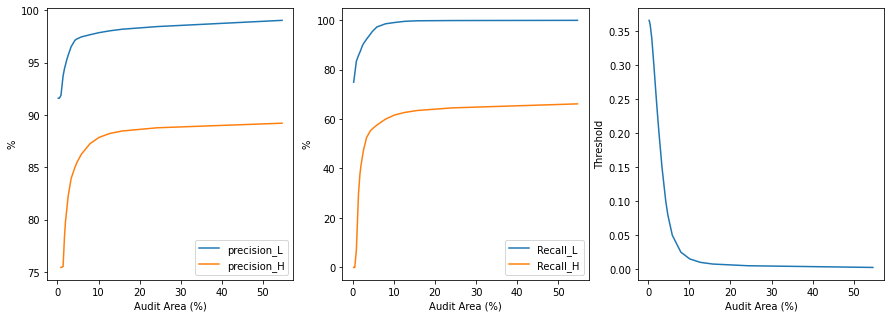

In [170]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.set_figheight(5)
fig.set_figwidth(15)
ax1.plot(m['AA']*100, m['precision_L']*100, label="precision_L")
ax1.plot(m['AA']*100, m['precision_H']*100, label="precision_H")
ax1.legend(loc="lower right")
ax1.set_ylabel('%')
ax1.set_xlabel('Audit Area (%)')

ax2.plot(m['AA']*100, m['recall_L']*100, label="Recall_L")
ax2.plot(m['AA']*100, m['recall_H']*100, label="Recall_H")
ax2.legend(loc="lower right")
ax2.set_ylabel('%')
ax2.set_xlabel('Audit Area (%)')

ax3.plot(m['AA']*100, np.asarray(threshold_list), label="AA")
ax3.set_xlabel('Audit Area (%)')
ax3.set_ylabel('Threshold')

# if save_figures == True:
if True:
    plt.savefig('output/figures/recall_precision_AA.png', dpi=150, bbox_inches='tight')

In [171]:
xlim = [-0.3, 12.7]
xlim = [-0.1, 10.4]

ylim = [0, 105]


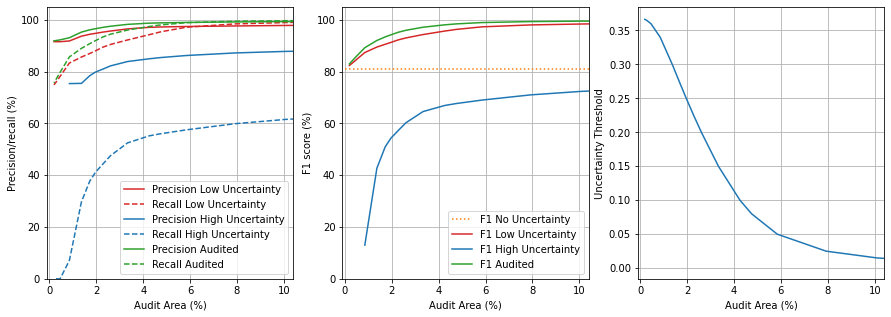

In [172]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.set_figheight(5)
fig.set_figwidth(15)
ax1.plot(m['AA']*100, m['precision_L']*100, 'C3-', label="Precision Low Uncertainty")
ax1.plot(m['AA']*100, m['recall_L']*100, 'C3--', label="Recall Low Uncertainty")
ax1.plot(m['AA']*100, m['precision_H']*100, 'C0-', label="Precision High Uncertainty")
ax1.plot(m['AA']*100, m['recall_H']*100, 'C0--', label="Recall High Uncertainty")
ax1.plot(m['AA']*100, m_audited['precision']*100, 'C2-', label="Precision Audited")
ax1.plot(m['AA']*100, m_audited['recall']*100, 'C2--', label="Recall Audited")

ax1.legend(loc="lower right")
ax1.set_ylabel('Precision/recall (%)')
ax1.set_xlabel('Audit Area (%)')
ax1.set_ylim(ylim)
ax1.set_xlim(xlim)
ax1.grid()

# ax2.plot(np.append(0, m['AA']*100), 
#     np.append(f1, np.ones_like(m['AA']) * f1), 
#     'C1:', label="F1 No Uncertainty")
ax2.plot(range(int(xlim[0]), int(xlim[1] + 2)), 
    np.ones(int(xlim[1] + 2)) * f1, 
    'C1:', label="F1 No Uncertainty")



ax2.plot(m['AA']*100, m['f1_L']*100, 'C3-', label="F1 Low Uncertainty")
ax2.plot(m['AA']*100, m['f1_H']*100, 'C0-', label="F1 High Uncertainty")
ax2.plot(m['AA']*100, m_audited['f1']*100, 'C2-', label="F1 Audited")

ax2.legend(loc="lower right")
ax2.set_ylabel('F1 score (%)')
ax2.set_xlabel('Audit Area (%)')
ax2.set_ylim(ylim)
ax2.set_xlim(xlim)

ax2.grid()
ax3.plot(m['AA']*100, np.asarray(threshold_list), label="AA")
ax3.set_xlabel('Audit Area (%)')
ax3.set_ylabel('Uncertainty Threshold')
ax3.grid()
ax3.set_xlim(xlim)



# if save_figures == True:
if True:
    plt.savefig('output/figures/recall_precision_f1_AA.png', dpi=150, bbox_inches='tight')

In [173]:
np.append(np.append(0, m['AA']*100), 10.5)

array([ 0.        , 54.67134555, 24.26999638, 15.71628941, 12.671024  ,
       10.10682329,  7.92830446,  5.84466168,  4.75078303,  4.25386267,
        3.33559362,  2.60908134,  2.27833926,  1.96365241,  1.72157284,
        1.36632188,  0.85233949,  0.45630019,  0.27697277,  0.19456643,
       10.5       ])

In [174]:
AA

0.03335593621681547

In [175]:


m

{'precision_L': array([0.9905078 , 0.98455116, 0.98201223, 0.98045612, 0.97873649,
        0.97676943, 0.97469775, 0.97277624, 0.9714669 , 0.96537169,
        0.95719948, 0.95299213, 0.94816544, 0.94456321, 0.93730329,
        0.91878673, 0.91600722, 0.91600722, 0.91600722]),
 'recall_L': array([0.99874049, 0.99794536, 0.99701628, 0.99485322, 0.9899436 ,
        0.98477914, 0.97195196, 0.95416053, 0.94288224, 0.92274036,
        0.90541336, 0.89471429, 0.88052135, 0.87044312, 0.85672538,
        0.8336591 , 0.78220951, 0.75902935, 0.7488631 ]),
 'recall_Ltotal': array([0.19041598, 0.2276333 , 0.25041472, 0.26706635, 0.28994406,
        0.32251415, 0.36782991, 0.39997309, 0.41839034, 0.4650889 ,
        0.52614447, 0.55954284, 0.5895805 , 0.61456141, 0.65569628,
        0.71545026, 0.72553589, 0.72553589, 0.72553589]),
 'AA': array([0.54671346, 0.24269996, 0.15716289, 0.12671024, 0.10106823,
        0.07928304, 0.05844662, 0.04750783, 0.04253863, 0.03335594,
        0.02609081, 0.022783

In [176]:
m_audited

{'precision': array([0.9981781 , 0.9964392 , 0.99543062, 0.99469735, 0.99372188,
        0.99235017, 0.99044128, 0.98871598, 0.98754882, 0.98293727,
        0.97571016, 0.97130213, 0.96615175, 0.96181564, 0.9530511 ,
        0.93129714, 0.92304647, 0.92043962, 0.91918549]),
 'recall': array([0.99975987, 0.99953133, 0.9992506 , 0.99861836, 0.99705459,
        0.99501519, 0.98938537, 0.98078462, 0.97465482, 0.96105882,
        0.94503479, 0.93415567, 0.91999935, 0.90852859, 0.89034452,
        0.85724544, 0.79798914, 0.76966258, 0.75668606]),
 'f1': array([0.99896836, 0.99798287, 0.99733695, 0.996654  , 0.99538544,
        0.99368089, 0.98991305, 0.98473433, 0.98105946, 0.97187493,
        0.96012752, 0.95236682, 0.9425109 , 0.93441303, 0.92063126,
        0.8927383 , 0.85597422, 0.83832556, 0.83005746])}

In [177]:
# exp

In [178]:
threshold_list

[0.0025,
 0.005,
 0.0075,
 0.01,
 0.015,
 0.025,
 0.05,
 0.08,
 0.1,
 0.15,
 0.2,
 0.225,
 0.25,
 0.27,
 0.3,
 0.34,
 0.36,
 0.3648794801235199,
 0.3663794801235199]

In [179]:
# threshold_list = [0.0025, 0.005, 0.0075, 0.01, 0.015, 0.025, 0.05, 0.08, 0.1, 0.15, 0.2, 0.225, 
#         0.25, 0.27, 0.3, 0.34, 0.36, np.max(uncertainty)-0.003, np.max(uncertainty)-0.0015]


In [180]:
predictor

<Predictor.pred_entropy: 3>

In [181]:

importlib.reload(_metrics)


# threshold_list = [0.005, 0.0075, 0.01, 0.015, 0.025, 0.05, 0.08, 0.1, 0.15, 0.2, 0.225, 
#         0.25, 0.27, 0.3, 0.34, 0.36, np.max(uncertainty)-0.003, np.max(uncertainty)-0.0015]
#threshold_list2 = [0.09] # exp 77 PA 50 runs
# threshold_list2 = [0.085] # exp 77 PA 30 runs
# threshold_list2 = [0.085] # exp 77 PA 10 runs
# threshold_list2 = [0.083] # exp 77 PA 5 runs
threshold_list2 = [0.065] # exp 77 PA 5 runs
threshold_list2 = [0.06] # exp 77 PA 5 runs
threshold_list2 = [0.0825] # exp 77 PA 3 runs

if predictor == Predictor.pred_entropy:
        if issubclass(type(dataset), PA):
                threshold_list2 = [0.163]
                threshold_list2 = [0.151]

        elif issubclass(type(dataset), MT):
                threshold_list2 = [0.116]
                threshold_list2 = [0.171]

ic(uncertainty.shape, label_mask_current_deforestation_test.shape)

metrics_values2 = _metrics.getAA_Recall(uncertainty, 
        label_mask_current_deforestation_test, 
        predicted_test, threshold_list2)

metric_values_audited2 = _metrics.getUncertaintyMetricsAudited(uncertainty, 
        label_mask_current_deforestation_test, 
        predicted_test, threshold_list2)



ic| uncertainty.shape: (44596080,)
    label_mask_current_deforestation_test.shape: (44596080,)


threshold 0.171
(43250161,) (43250161,)


ic| label_current_deforestation_test_classified_incorrect.shape: (1345919,)
    predicted_test_classified_incorrect.shape: (1345919,)
ic| TP_H + FN_H + FP_H + TN_H: 1345919
    len(label_mask_current_deforestation_test): 44596080
ic| TP_H + FN_H 

cm_correct [[42773489    16797]
 [   38715   421160]]
cm_incorrect [[903225  40551]
 [197878 204265]]


+ FP_H + TN_H: 1345919
    len(label_mask_current_deforestation_test): 44596080


[0.96164692 0.91581408 0.48857448 0.03018021 0.83436132 0.5079412 ]
threshold 0.171
(44596080,) (44596080,)
cm_audited [[43717265    16797]
 [   38715   823303]]
[0.98000595 0.95508794]


In [182]:
m2 = {'precision_L': metrics_values2[:,0],
        'recall_L': metrics_values2[:,1],
        'recall_Ltotal': metrics_values2[:,2],
        'AA': metrics_values2[:,3],
        'precision_H': metrics_values2[:,4],
        'recall_H': metrics_values2[:,5]}

m_audited2 = {'precision': metric_values_audited2[:,0],
        'recall': metric_values_audited2[:,1]}

m2['f1_L'] = 2*m2['precision_L']*m2['recall_L']/(m2['precision_L']+m2['recall_L'])
m2['f1_H'] = 2*m2['precision_H']*m2['recall_H']/(m2['precision_H']+m2['recall_H'])

m_audited2['f1'] = 2*m_audited2['precision']*m_audited2['recall']/(m_audited2['precision']+m_audited2['recall'])

ic(m2)
ic(m_audited2)


ic| m2: {'AA': array([0.03018021]),
         'f1_H': array([0.63146196]),
         'f1_L': array([0.93817106]),
         'precision_H': array([0.83436132]),
         'precision_L': array([0.96164692]),
         'recall_H': array([0.5079412]),
         'recall_L': array([0.91581408]),
         'recall_Ltotal': array([0.48857448])}
ic| m_audited2: {'f1': array([0.96738651]),
                 'precision': array([0.98000595]),
                 'recall': array([0.95508794])}


{'precision': array([0.98000595]),
 'recall': array([0.95508794]),
 'f1': array([0.96738651])}

In [183]:
pred_entropy_unpad = utils_v1.unpadIm(pred_entropy, npad)
ic(pred_entropy_unpad.shape)

threshold_uncertainty = 0.1

uncertainty_mask = np.zeros_like(pred_entropy_unpad).astype(np.int8)
uncertainty_mask[pred_entropy_unpad >= threshold_uncertainty] = 1
ic(np.unique(uncertainty_mask, return_counts=True))


ic| pred_entropy_unpad.shape: (16795, 10420)
ic| np.unique(uncertainty_mask, return_counts=True): (array([0, 1], dtype=int8), array([168742875,   6261025], dtype=int64))


(array([0, 1], dtype=int8), array([168742875,   6261025], dtype=int64))

(-0.5, 10419.5, 16794.5, -0.5)

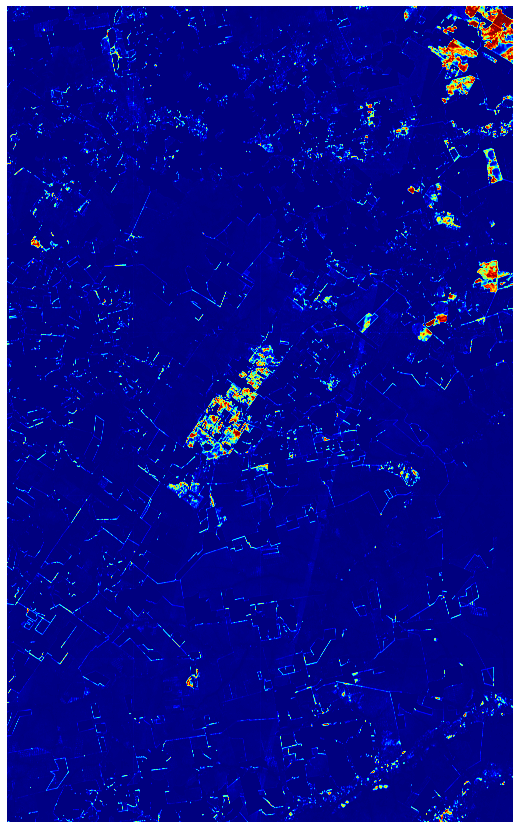

In [184]:
fig, ax = plt.subplots(figsize=(15,15))
ax.set_xticks([])
ax.set_yticks([])
ax.imshow(pred_entropy_to_show, cmap='jet')
plt.axis('off')


(-0.5, 10419.5, 16794.5, -0.5)

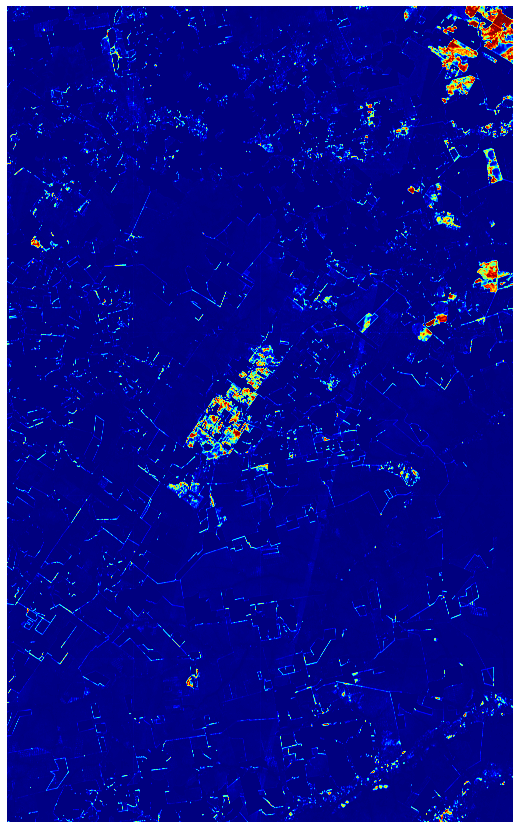

In [185]:

fig, ax = plt.subplots(figsize=(15,15))
ax.set_xticks([])
ax.set_yticks([])
ax.imshow(pred_entropy_to_show, cmap='jet')
plt.axis('off')


(-0.5, 10419.5, 16794.5, -0.5)

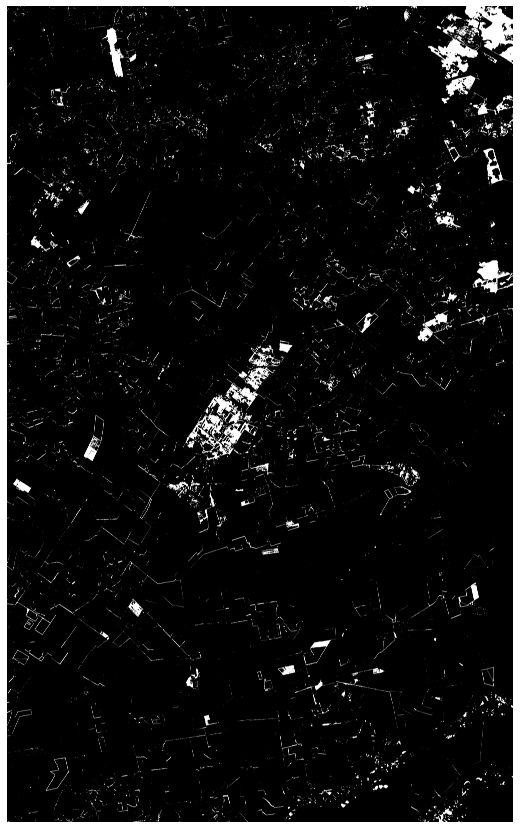

In [186]:
fig, ax = plt.subplots(figsize=(15,15))
ax.set_xticks([])
ax.set_yticks([])
ax.imshow(uncertainty_mask, cmap=plt.cm.gray)
plt.axis('off')


In [187]:
config = {
	"training": False,
	"save_probabilities": False,
	"loadInference": False,
	"addPastDeforestationInput": True,
	"inference_times": 10
}

import src.trainer.base as t
importlib.reload(t)
trainer = t.Trainer(config, dataset, patchesHandler)


In [188]:
trainer.uncertainty = uncertainty
trainer.label_mask_current_deforestation_test = label_mask_current_deforestation_test
trainer.predicted_test = predicted_test


In [189]:
trainer.getOptimalUncertaintyThreshold(bound = 0.0015)

ic| bounds: (0.0015, 0.3663794801235199)
c:\Users\jchamorro\Anaconda3\envs\tf2\lib\site-packages\scipy\optimize\_minimize.py:783: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  warn("Method 'bounded' does not support relative tolerance in x; "


0.1408715596097929
threshold 0.1408715596097929
(43042445,) (43042445,)


ic| label_current_deforestation_test_classified_incorrect.shape: (1553635,)
    predicted_test_classified_incorrect.shape: (1553635,)
ic

cm_correct [[42605137    13331]
 [   31381   392596]]
cm_incorrect [[1071577   44017]
 [ 205212  232829]]


| TP_H + FN_H + FP_H + TN_H: 1553635
    len(label_mask_current_deforestation_test): 44596080
ic| TP_H + FN_H + FP_H + TN_H: 1553635
    len(label_mask_current_deforestation_test): 44596080


[0.96715912 0.92598419 0.45543829 0.03483793 0.84100547 0.5315233 ]
0.22700792051372695
threshold 0.22700792051372695
(43591532,) (43591532,)


ic| label_current_deforestation_test_classified_incorrect.shape: (1004548,)
    predicted_test_classified_incorrect.shape: (1004548,)
ic| TP_H + FN_H + FP_H + TN_H: 1004548
    len(label_mask_current_deforestation_test): 44596080
ic| TP_H + FN_H + FP_H + TN_H: 1004548
    len(label_mask_current_deforestation_test): 44596080


cm_correct [[43025252    24132]
 [   57624   484524]]
cm_incorrect [[651462  33216]
 [178969 140901]]
[0.95255733 0.89371168 0.56208107 0.02252548 0.80923172 0.44049458]
0.08763636090393405
threshold 0.08763636090393405
(42568338,) (42568338,)


ic| label_current_deforestation_test_classified_incorrect.shape: (2027742,)
    predicted_test_classified_incorrect.shape: (2027742,)


cm_correct [[42188742     9988]
 [   18529   351079]]


ic| TP_H + FN_H + FP_H + TN_H: 2027742
    len(label_mask_current_deforestation_test): 44596080
ic| TP_H + FN_H + FP_H + TN_H: 2027742
    len(label_mask_current_deforestation_test): 44596080


cm_incorrect [[1487972   47360]
 [ 218064  274346]]
[0.97233754 0.94986851 0.40727572 0.04546906 0.85278484 0.55714953]
0.17467812452458992
threshold 0.17467812452458992
(43273777,) (43273777,)


ic| label_current_deforestation_test_classified_incorrect.shape: (1322303,)
    predicted_test_classified_incorrect.shape: (1322303,)
ic| TP_H + FN_H + FP_H + TN_H: 1322303
    len(label_mask_current_deforestation_test): 44596080
ic| TP_H + FN_H + FP_H + TN_H: 1322303
    len(label_mask_current_deforestation_test): 44596080


cm_correct [[42791908    17206]
 [   39720   424943]]
cm_incorrect [[884806  40142]
 [196873 200482]]
[0.96108552 0.91451869 0.49296302 0.02965066 0.83317541 0.50454128]
0.17903775982113015
threshold 0.17903775982113015
(43301658,) (43301658,)


ic| label_current_deforestation_test_classified_incorrect.shape: (1294422,)
    predicted_test_classified_incorrect.shape: (1294422,)
ic| TP_H + FN_H + FP_H + TN_H: 1294422
    len(label_mask_current_deforestation_test): 44596080
ic| TP_H + FN_H + FP_H + TN_H: 1294422
    len(label_mask_current_deforestation_test): 44596080


cm_correct [[42813547    17706]
 [   40865   429540]]
cm_incorrect [[863167  39642]
 [195728 195885]]
[0.96041105 0.91312805 0.49829586 0.02902547 0.83168809 0.50020045]
0.16694908536978506
threshold 0.16694908536978506
(43223772,) (43223772,)


ic| label_current_deforestation_test_classified_incorrect.shape: (1372308,)
    predicted_test_classified_incorrect.shape: (1372308,)
ic| TP_H + FN_H + FP_H + TN_H: 1372308
    len(label_mask_current_deforestation_test): 44596080
ic| TP_H + FN_H + FP_H + TN_H: 

cm_correct [[42752614    16352]
 [   37668   417138]]
cm_incorrect [[924100  40996]
 [198925 208287]]


1372308
    len(label_mask_current_deforestation_test): 44596080


[0.96227825 0.91717787 0.48390869 0.03077194 0.83554434 0.51149524]
0.17172589426783322
threshold 0.17172589426783322
(43254828,) (43254828,)


ic| label_current_deforestation_test_classified_incorrect.shape: (1341252,)
    predicted_test_classified_incorrect.shape: (1341252,)
ic| TP_H + FN_H + FP_H + TN_H: 1341252
    len(label_mask_current_deforestation_test): 44596080
ic| TP_H + FN_H + FP_H + TN_H: 1341252
    len(label_mask_current_deforestation_test): 44596080


cm_correct [[42777151    16875]
 [   38917   421885]]
cm_incorrect [[899563  40473]
 [197676 203540]]
[0.96153934 0.91554507 0.48941553 0.03007556 0.83413589 0.50730778]
0.17169255838739325
threshold 0.17169255838739325
(43254613,) (43254613,)


ic| label_current_deforestation_test_classified_incorrect.shape: (1341467,)
    predicted_test_classified_incorrect.shape: (1341467,)
ic| TP_H + FN_H + FP_H + TN_H: 

cm_correct [[42776982    16871]
 [   38907   421853]]
cm_incorrect [[899732  40477]
 [197686 203572]]


1341467
    len(label_mask_current_deforestation_test): 44596080
ic| TP_H + FN_H + FP_H + TN_H: 1341467
    len(label_mask_current_deforestation_test): 44596080


[0.9615453  0.91555908 0.48937841 0.03008038 0.83414396 0.50733443]
0.1726187630461833
threshold 0.1726187630461833
(43260608,) (43260608,)


ic| label_current_deforestation_test_classified_incorrect.shape: (1335472,)
    predicted_test_classified_incorrect.shape: (1335472,)
ic| TP_H + FN_H + FP_H + TN_H: 1335472
    len(label_mask_current_deforestation_test): 44596080
ic| TP_H + FN_H + FP_H + TN_H: 1335472
    len(label_mask_current_deforestation_test):

cm_correct [[42781639    16963]
 [   39175   422831]]
cm_incorrect [[895075  40385]
 [197418 202594]]


 44596080


[0.96142967 0.91520673 0.49051296 0.02994595 0.83379222 0.50646981]
0.1734053691358124
threshold 0.1734053691358124
(43265543,) (43265543,)


ic| label_current_deforestation_test_classified_incorrect.shape: (1330537,)
    predicted_test_classified_incorrect.shape: (1330537,)
ic| TP_H + FN_H + FP_H + TN_H: 1330537
    len(label_mask_current_deforestation_test): 44596080
ic| TP_H + FN_H + FP_H + TN_H: 1330537


cm_correct [[42785505    17044]
 [   39381   423613]]
cm_incorrect [[891209  40304]
 [197212 201812]]


    len(label_mask_current_deforestation_test): 44596080


[0.96132139 0.91494274 0.49142013 0.02983529 0.83353434 0.50576406]
0.1722648842106805
threshold 0.1722648842106805
(43258240,) (43258240,)


ic| label_current_deforestation_test_classified_incorrect.shape: (1337840,)
    predicted_test_classified_incorrect.shape: (1337840,)
ic| TP_H + 

cm_correct [[42779781    16931]
 [   39067   422461]]
cm_incorrect [[896933  40417]
 [197526 202964]]


FN_H + FP_H + TN_H: 1337840
    len(label_mask_current_deforestation_test): 44596080
ic| TP_H + FN_H + FP_H + TN_H: 1337840
    len(label_mask_current_deforestation_test): 44596080


[0.96146721 0.91535291 0.49008373 0.02999905 0.83393527 0.50678918]
0.17220960930326587
threshold 0.17220960930326587
(43257895,) (43257895,)


ic| label_current_deforestation_test_classified_incorrect.shape: (1338185,)
    predicted_test_classified_incorrect.shape: (1338185,)
ic| TP_H + FN_H + FP_H + TN_H: 1338185
    len(label_mask_current_deforestation_test): 44596080
ic| TP_H + FN_H + FP_H + TN_H: 1338185
    len(label_mask_current_deforestation_test): 44596080


cm_correct [[42779513    16926]
 [   39055   422401]]
cm_incorrect [[897201  40422]
 [197538 203024]]
[0.96147289 0.91536571 0.49001413 0.03000679 0.83395907 0.50684788]
0.17232173017697563
threshold 0.17232173017697563
(43258637,) (43258637,)


ic| label_current_deforestation_test_classified_incorrect.shape: (1337443,)
    predicted_test_classified_incorrect.shape: (1337443,)
ic| TP_H + FN_H + FP_H + TN_H: 1337443
    len(label_mask_current_deforestation_test): 44596080
ic| TP_H + FN_H + FP_H + TN_H:

cm_correct [[42780097    16936]
 [   39077   422527]]
cm_incorrect [[896617  40412]
 [197516 202898]]


 1337443
    len(label_mask_current_deforestation_test): 44596080
ic| self.threshold_optimal: 0.1722648842106805


[0.96146206 0.91534519 0.4901603  0.02999015 0.83390736 0.50672054]


In [190]:
trainer.threshold_optimal

0.1722648842106805

In [191]:
trainer.getUncertaintyMetricsFromOptimalThreshold()

threshold 0.1722648842106805
(43258240,) (43258240,)


ic| label_current_deforestation_test_classified_incorrect.shape: (1337840,)
    predicted_test_classified_incorrect.shape: (1337840,)
ic| TP_H + FN_H + FP_H + TN_H: 1337840
    len(label_mask_current_deforestation_test): 44596080
ic| TP_H +

cm_correct [[42779781    16931]
 [   39067   422461]]
cm_incorrect [[896933  40417]
 [197526 202964]]


 FN_H + FP_H + TN_H: 1337840
    len(label_mask_current_deforestation_test): 44596080


[0.96146721 0.91535291 0.49008373 0.02999905 0.83393527 0.50678918]
threshold 0.1722648842106805
(44596080,) (44596080,)
cm_audited [[43717131    16931]
 [   39067   822951]]
[0.97984122 0.9546796 ]


AttributeError: 'Trainer' object has no attribute 'f1'